In [1]:
import astropy
from astropy.table import Table
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#from bayesn import SEDmodel
import pandas as pd
#import jax.random as jr
#from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import sncosmo
import emcee
import nestle
import corner
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
import pickle

In [4]:
head_table = Table(fits.open(f"/global/cfs/cdirs/lsst/www/jolteon/data/FINAL2/JOLTEON_FINAL_0000_HEAD.FITS")[1].data)
phot_table = Table(fits.open(f"/global/cfs/cdirs/lsst/www/jolteon/data/FINAL2/JOLTEON_FINAL_0000_PHOT.FITS")[1].data)

print("HEAD columns:", head_table.colnames)
print("PHOT columns:", phot_table.colnames)

allowed_labels = ['SNIa-SALT3', 'glSNIa_ASM']

filter_mask = False
for label in allowed_labels:
    filter_mask = filter_mask | (head_table['LABEL'] == label)

head_table = head_table[filter_mask]
print(len(head_table))

model_s = sncosmo.Model(source='salt3', effects=[sncosmo.OD94Dust()], effect_names=['mw'], effect_frames=['obs'])
#model_b = SEDmodel(load_model='BAYESN_1.YAML')

HEAD columns: ['SNID', 'RA', 'DEC', 'MWEBV', 'MWEBV_ERR', 'SPECZ', 'SPECZ_ERR', 'PHOTOZ', 'PHOTOZ_ERR', 'NOBS', 'MJD_DETECT_FIRST', 'MJD_DETECT_LAST', 'PTROBS_MIN', 'PTROBS_MAX', 'LABEL']
PHOT columns: ['MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR', 'SKY_SIG', 'PSF', 'ZEROPT', 'SIM_MAGOBS']
2525


In [33]:
class snia:
    def __init__(self, snid, label, ra, dec, z, lc, peak_mjd, mw_ebv, lensed=False, sus=False):
        self.snid = snid          #string
        self.label = label        #string
        self.ra = ra              #float
        self.dec = dec            #float
        self.z = z                #float
        self.lc = lc              #astropy Table
        self.peak_mjd = peak_mjd  #float
        self.mw_ebv = mw_ebv      #float
        self.lensed = lensed      #boolean
        self.sus = sus        #boolean; for marking abnormal SNs

    def calc_mu_exp(self, H0_value = 73.6, Om0_value = 0.334):
        cosmo = FlatLambdaCDM(H0=H0_value * u.km / u.s / u.Mpc, Om0=Om0_value)
        mu_exp = cosmo.distmod(self.z)
        return mu_exp

    def sn_plot(self, colors = {'u': '#9467bd', 'g': '#377eb8', 'r': '#4daf4a', 'i': '#e3c530', 'z': '#ff7f00'}, markers = {0: 'o', 1: '^'}):
        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        ax.scatter(self.lc['MJD'], self.lc['SIM_MAGOBS'], c=[colors[band] for band in self.lc['BAND']], alpha = 0.5)
        ax.set_ylim(37,18)
    
        legend_patches = [mpatches.Patch(color=color, label=band.strip()) for band, color in colors.items()]
        ax.legend(handles=legend_patches, title="Bands", fontsize=14, title_fontsize=16, ncol=3)
        plt.gca().invert_yaxis()
        ax.set_xlabel("MJD", fontsize=18)
        ax.set_ylabel("Apparent Magnitude", fontsize=18)
        ax.set_title(f'JOLTEON ID: {self.snid}', fontsize=24)
        fig.tight_layout()
        plt.show()

    def prep_lc(self, lcc, time_window_min=-20, time_window_max=50):
        lcc = lcc[lcc['FLUXCAL'] > 0]
        lcc = lcc[lcc['FLUXCALERR'] > 0]
        lcc['m'] = -2.5 * np.log10(lcc['FLUXCAL']) + 27.5
        lcc['dm'] = np.abs(-2.5 * lcc['FLUXCALERR'] / (np.log(10) * lcc['FLUXCAL']))
        lcc = lcc.dropna(subset=['m', 'dm', 'BAND'])

        mask = np.isfinite(lcc['m']) & np.isfinite(lcc['dm']) & (lcc['BAND'] != '')
        lcc = lcc[mask]

        relative_mjd = lcc['MJD'] - self.peak_mjd
        time_window_mask = (relative_mjd >= time_window_min) & (relative_mjd <= time_window_max)
        lcc = lcc[time_window_mask]
        return lcc

    def sncosmo_fit(self, model, alpha=0.14, beta=3.1, M0=-19.0, mw_rv=3.1, filt_map = {'g': 'lsstg','r': 'lsstr','i': 'lssti','z': 'lsstz', 'u': 'lsstu'}):   
        lcs = self.lc.to_pandas() 
        mapped_filt_s = [filt_map.get(f, f) for f in lcs['BAND']]
        lcs['BAND'] = mapped_filt_s
        lcs = self.prep_lc(lcs)

        lcs = lcs.rename(columns={'FLUXCAL': 'FLUX', 'FLUXCALERR': 'FLUXERR'})  #rename the columns so sncosmo knows what im doing
        lcs = Table.from_pandas(lcs)   #convert pandas dataframe into astropy Table that sncosmo requires; "s" for sncosmo
        new_column_values = ["ab"] * len(lcs)   #add magnitude system so sncosmo knows what im doing
        lcs['zpsys'] = new_column_values        #only works after lc has been converted into an astropy Table

        model.set(z=self.z)
        model.set(t0=self.peak_mjd)
        result, fitted_model = sncosmo.nest_lc(lcs, model,['x0', 'x1', 'c'], fixed={'mw_ebv': self.mw_ebv, 'mw_rv': mw_rv}, guess_ampitude_bound=True, bounds={'x1':(0.5, 2.2), 
                            'c':(-0.4, 0.6),'x0':(-0.003, 0.003)}, guess_z=False, minsnr=0, guess_t0=False)  

        x0_fit = fitted_model.parameters[fitted_model.param_names.index('x0')]
        m_B = -2.5 * np.log10(x0_fit)+10.635-.27
        x1_fit = fitted_model.parameters[fitted_model.param_names.index('x1')]
        c_fit = fitted_model.parameters[fitted_model.param_names.index('c')]
        x0_fit_err = result.errors['x0']
        x1_fit_err = result.errors['x1']
        c_fit_err = result.errors['c']

        def salt2mu(x1=None,x1err=None,
                c=None,cerr=None,
                mb=None,mberr=None, #error of the x0
                cov_x1_c=0,cov_x1_x0=0,cov_c_x0=0,
                alpha=None,beta=None,hostmass=None,
                M=None,x0=None,sigint=None,z=None,peczerr=0.00083,deltam=None):

            sf = -2.5/(x0*np.log(10.0))
            cov_mb_c = cov_c_x0*sf
            cov_mb_x1 = cov_x1_x0*sf
            mu_out = mb + x1*alpha - beta*c - M0
            invvars = 1.0 / (mberr**2.+ alpha**2. * x1err**2. + beta**2. * cerr**2. + \
                   2.0 * alpha * (cov_x1_x0*sf) - 2.0 * beta * (cov_c_x0*sf) - \
                   2.0 * alpha*beta * (cov_x1_c) )

            if deltam:
                if len(np.where(hostmass > 10)[0]):
                    mu_out[hostmass > 10] += deltam/2.
                if len(np.where(hostmass < 10)[0]):
                    mu_out[hostmass < 10] -= deltam/2.

            zerr = peczerr*5.0/np.log(10)*(1.0+z)/(z*(1.0+z/2.0))
            muerr_out = np.sqrt(1/invvars + zerr**2. + 0.055**2.*z**2.)
            if sigint: muerr_out = np.sqrt(muerr_out**2. + sigint**2.)
            return(mu_out,muerr_out)

        mu_obs, mu_obs_err = salt2mu(x1=x1_fit, x1err=x1_fit_err, c=c_fit, cerr=c_fit_err, mb=m_B, mberr=x0_fit_err, alpha=alpha, beta=beta, M=M0, x0=x0_fit, z=self.z)

        return result, fitted_model, mu_obs, mu_obs_err

    def bayesn_fit(self, model, filt_map = {'g': 'g_LSST', 'r': 'r_LSST', 'i': 'i_LSST', 'z': 'z_LSST', 'u': 'u_LSST'}):
        lcb = self.lc.to_pandas()
        mapped_filt_b = [filt_map.get(f, f) for f in lcb['BAND']]
        lcb['BAND'] = mapped_filt_b
        lcb = self.prep_lc(lcb)
    
        samples, sn_props = model.fit(
                lcb['MJD'], lcb['m'], lcb['dm'], lcb['BAND'],
                z=self.z, peak_mjd=self.peak_mjd,
                ebv_mw=self.mw_ebv,
                filt_map=filt_map, 
                mag=True)
        
        mu_obs = np.mean(samples['Ds'])
        mu_obs_err = np.std(samples['Ds'])
        
        return samples, sn_props, mu_obs, mu_obs_err

In [6]:
def obtain_data(head_table, idx):
    snid = head_table[idx]['SNID']
    label = head_table[idx]['LABEL']
    ra = head_table[idx]['RA']
    dec = head_table[idx]['DEC']
    z = head_table[idx]['PHOTOZ']
    ptr_min = head_table[idx]['PTROBS_MIN']
    ptr_max = head_table[idx]['PTROBS_MAX']
    lc = phot_table[ptr_min-1:ptr_max]
    peak_mjd = lc['MJD'][lc['SIM_MAGOBS'].argmin()]
    

    coords_sn = SkyCoord(ra * u.deg, dec * u.deg, frame='icrs')
    sfd_query = SFDQuery() 
    mw_ebv = sfd_query(coords_sn)

    return snid, label, ra, dec, z, lc, peak_mjd, mw_ebv


In [8]:
sn_list = []
for idx in range(len(head_table['SNID'])):
    try:
        (snid_val, label_val, ra_val, dec_val, z_val, lc_val, peak_mjd_val, mw_ebv_val) = obtain_data(head_table, idx)

        if np.isnan(peak_mjd_val):
            print(f"Skipping SNID {snid_val} due to missing peak MJD.")
            continue 
            
        sn = snia(
            snid=snid_val,
            label=label_val,
            ra=ra_val,
            dec=dec_val,
            z=z_val,
            lc=lc_val,
            peak_mjd=peak_mjd_val,
            mw_ebv=mw_ebv_val)

        try:
            result, fitted_model, mu_s, mu_s_err = sn.sncosmo_fit(model_s)
        except Exception as e:
            print(f"SNCosmo fit failed for SNID {sn.snid}: {e}")
            mu_s, mu_s_err = np.nan, np.nan 

        #try:
        #    samples, sn_props, mu_b, mu_b_err = sn.bayesn_fit(model_b)
        #except Exception as e:
        #    print(f"BayesN fit failed for SNID {sn.snid}: {e}")
        #    mu_b, mu_b_err = np.nan, np.nan

        mu_exp = sn.calc_mu_exp()
        sn.mu_s = mu_s
        #sn.mu_b = mu_b
        sn.mu_exp = mu_exp
        sn.result = result
        sn.fitted_model = fitted_model

        #if not np.isnan(sn.mu_s) and not np.isnan(sn.mu_b) and abs(sn.mu_s - sn.mu_b) > 1:
        #    sn.sus = True
        #else:
        #    sn.sus = False 

        sn_list.append(sn)
        if (idx + 1) % 100 == 0:  # The +1 is to make it print for 100, 200, etc.
            print(idx + 1, '/', len(head_table))

    except IndexError as e:
        print(f"IndexError processing idx {idx}: {e}. This might mean head_table indexing issue.")
        continue

    except Exception as e:
        print(f"An unexpected error occurred for idx {idx}: {e}")
        continue 
        

/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

100 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu, lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/r

200 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

300 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

400 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu, lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/r

500 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

600 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

700 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

800 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

900 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu, lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/r

1000 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu, lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/r

1100 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

1200 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

1300 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

1400 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

1500 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

1600 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

1700 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

1800 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

1900 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

2000 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

2100 / 2525
SNCosmo fit failed for SNID 104188: No bands in data overlap the model.


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu, lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/r

2200 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu, lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/r

2300 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

2400 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang

2500 / 2525


/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstg(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/global/homes/r/rayliang/.conda/envs/jolteon/lib/python3.10/site-packages/sncosmo/fitting.py:191: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


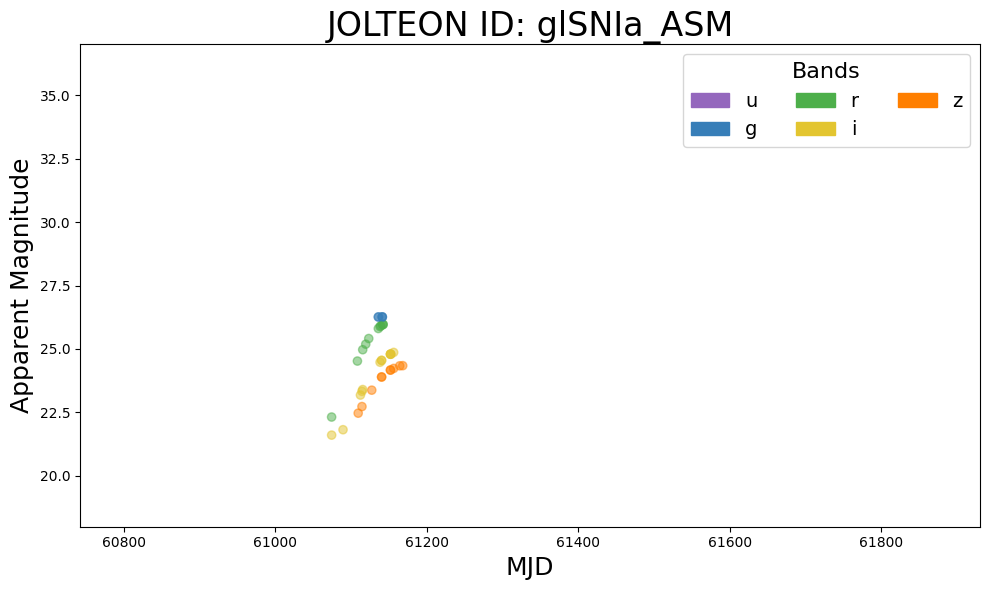

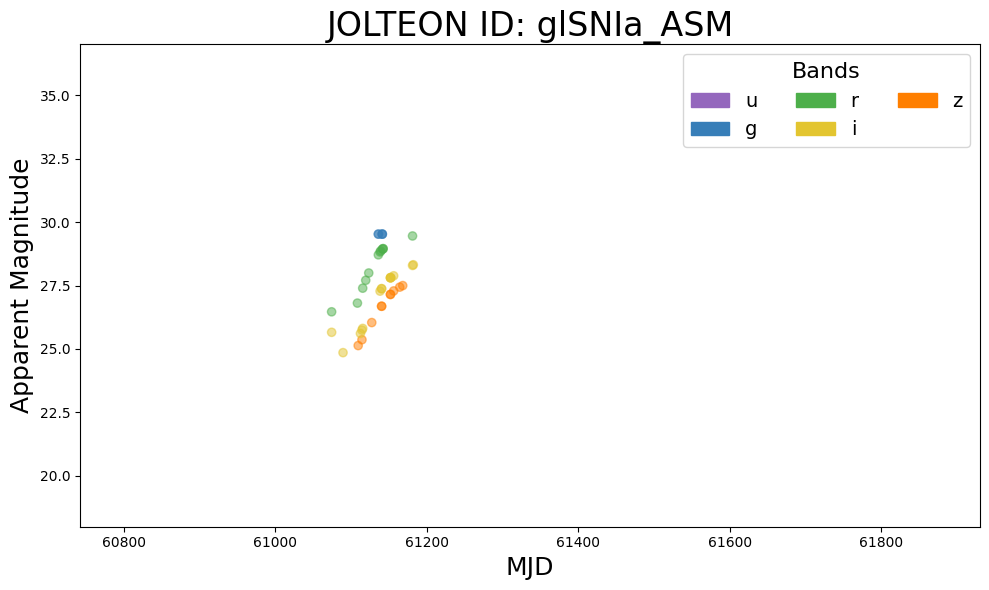

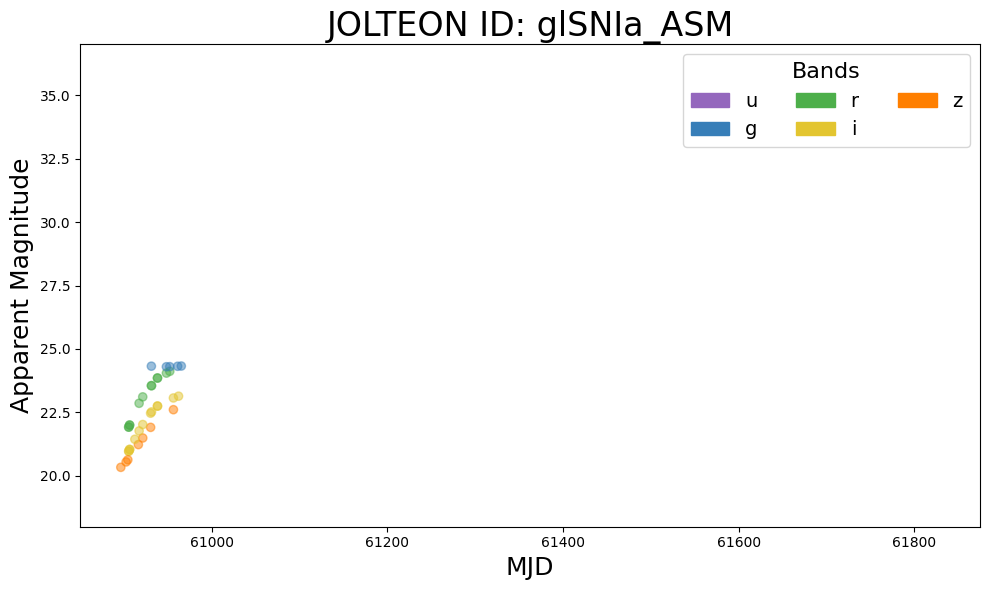

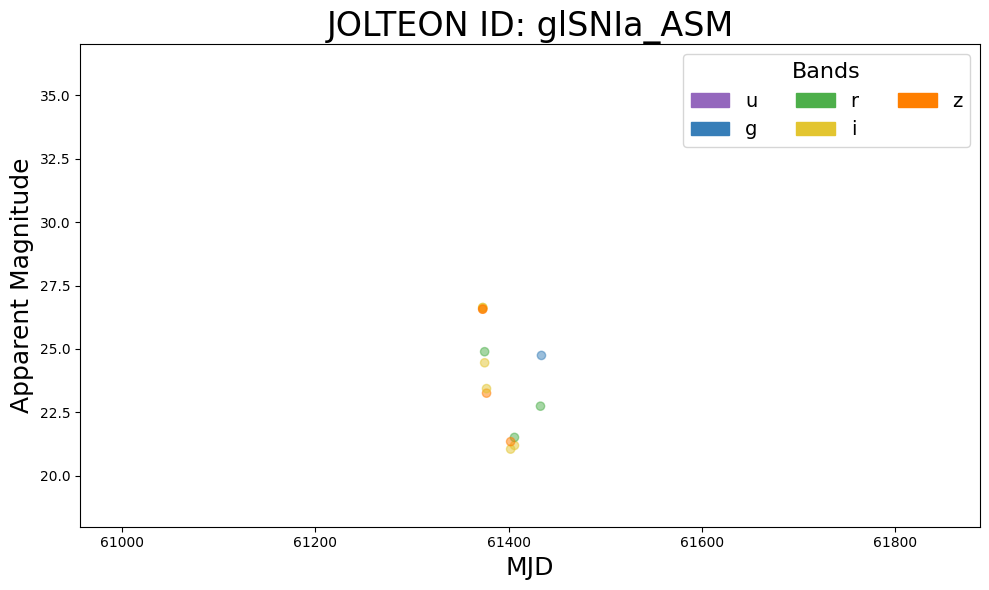

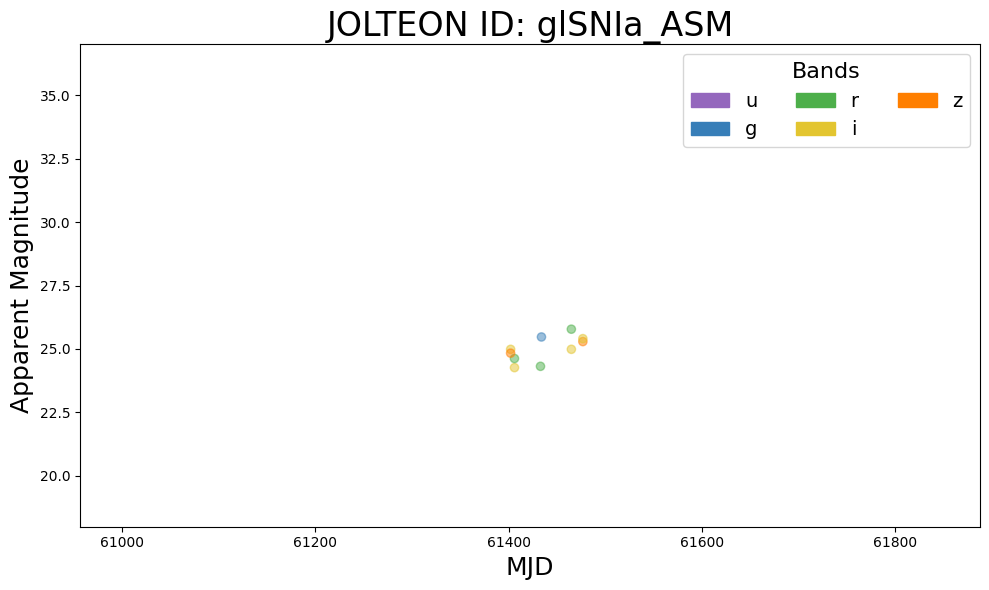

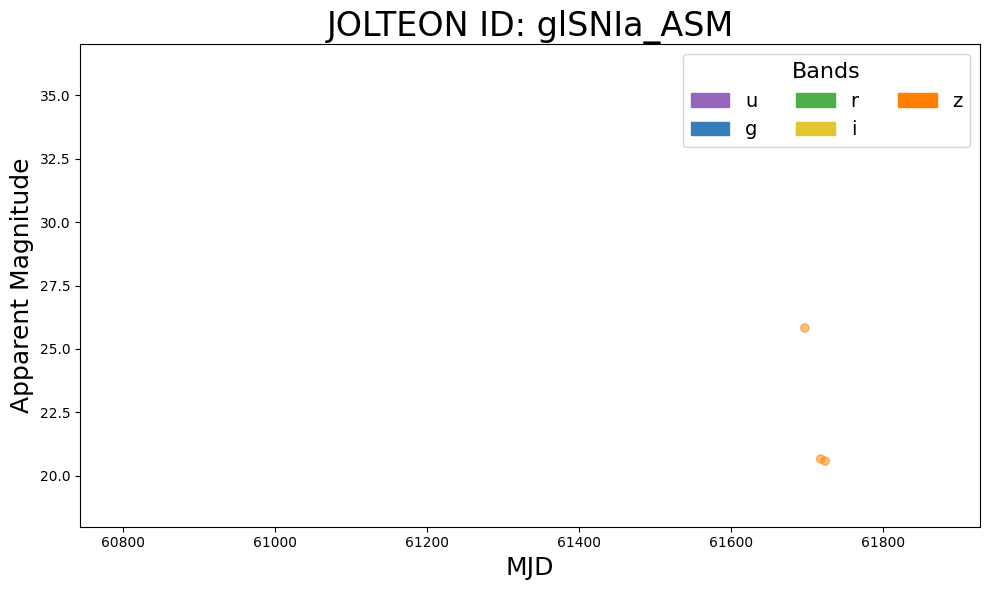

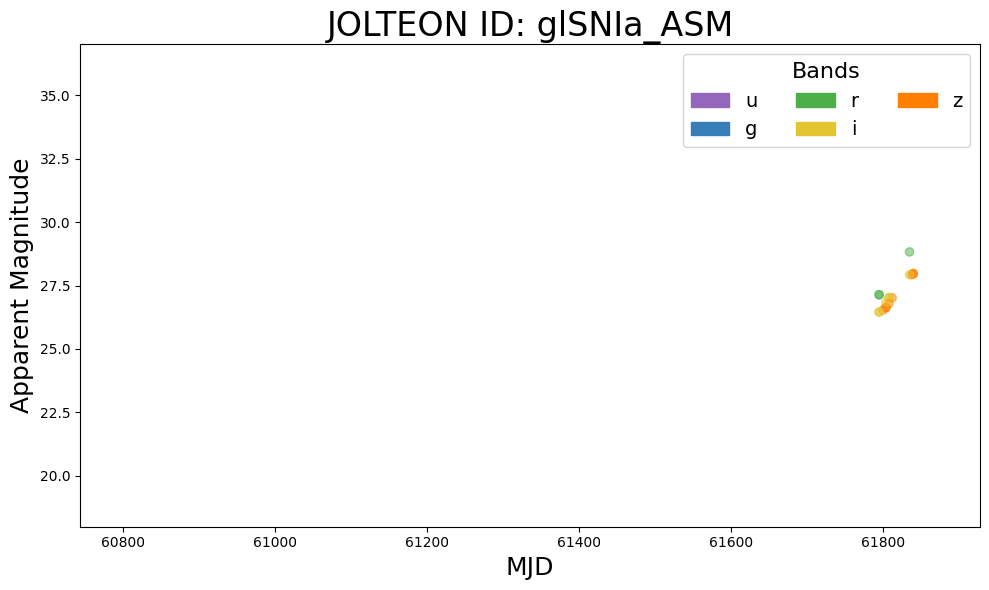

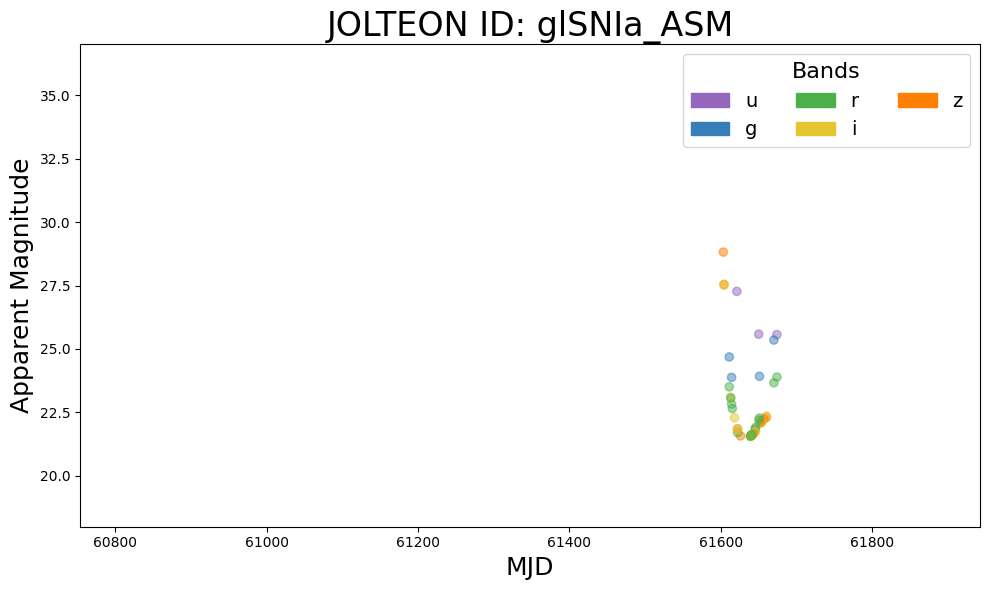

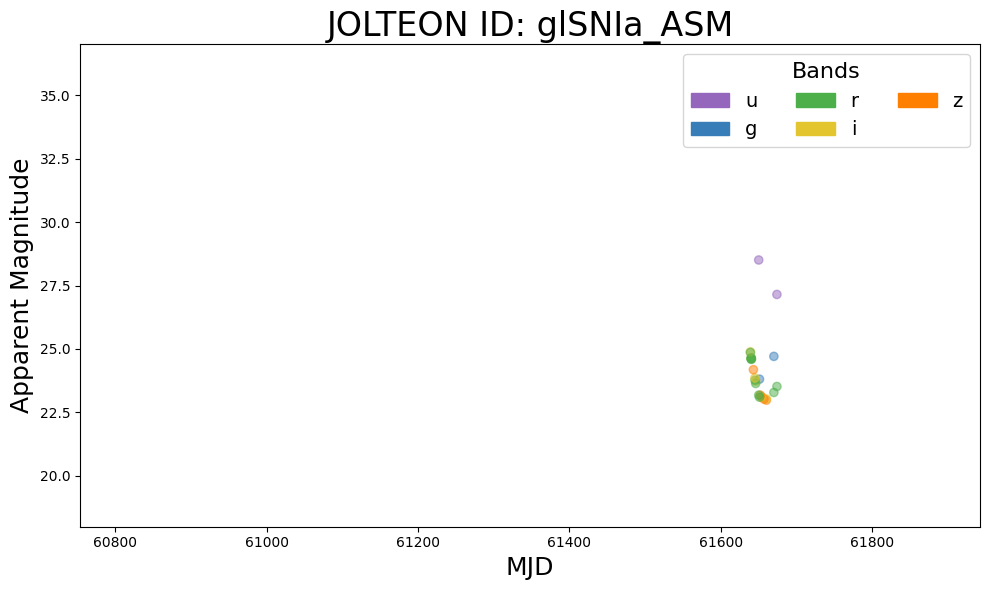

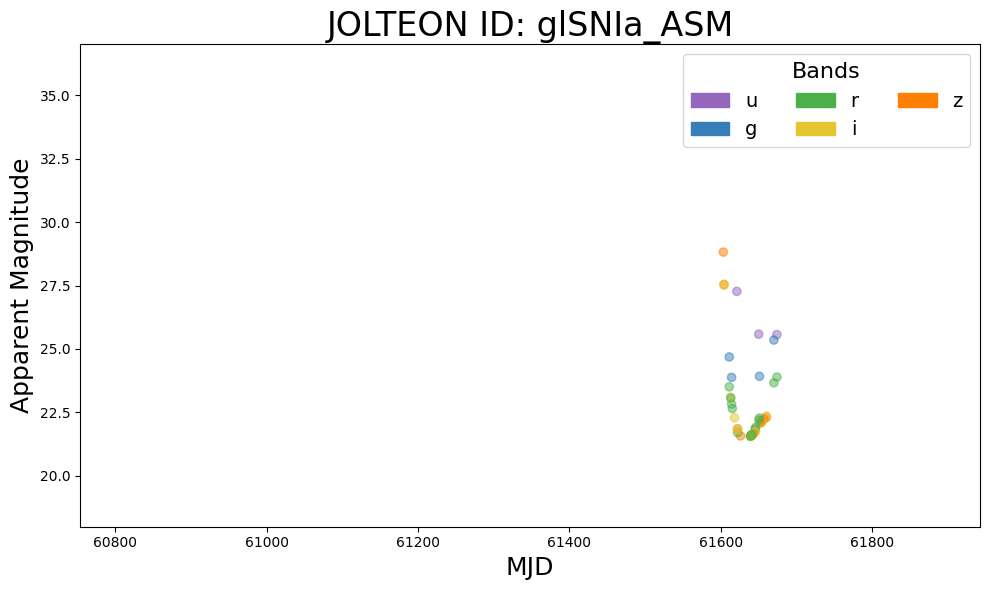

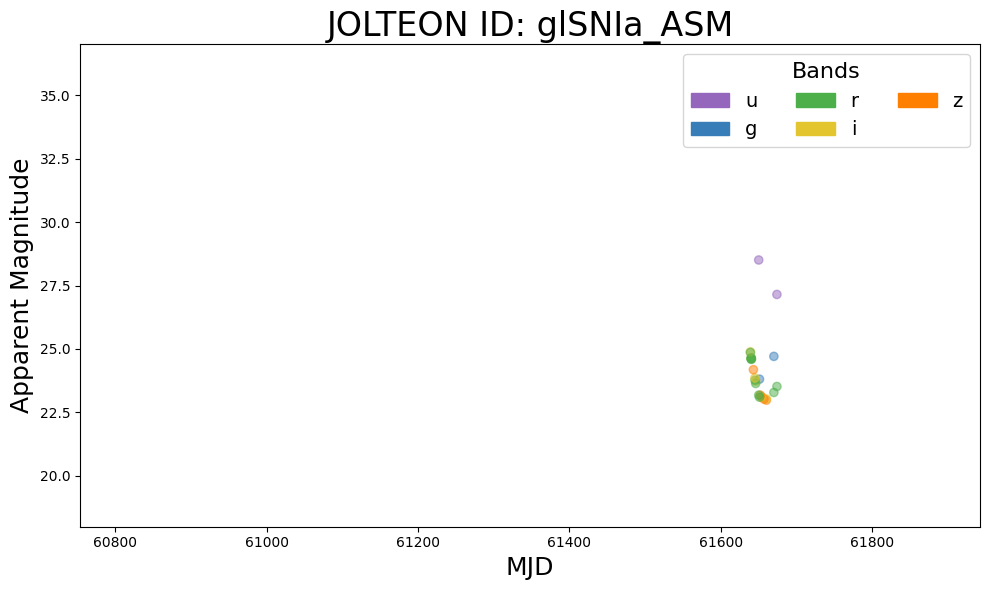

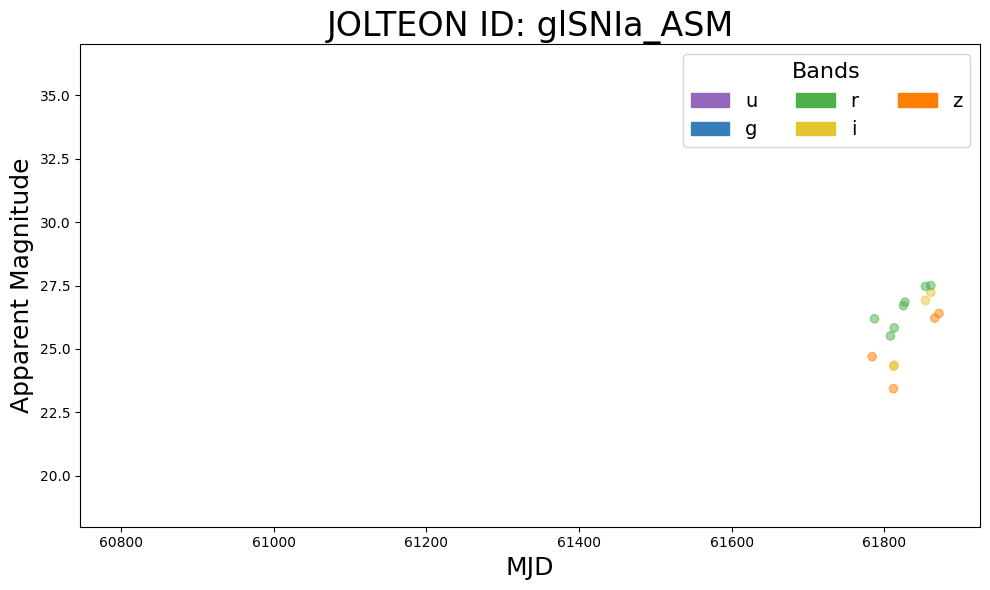

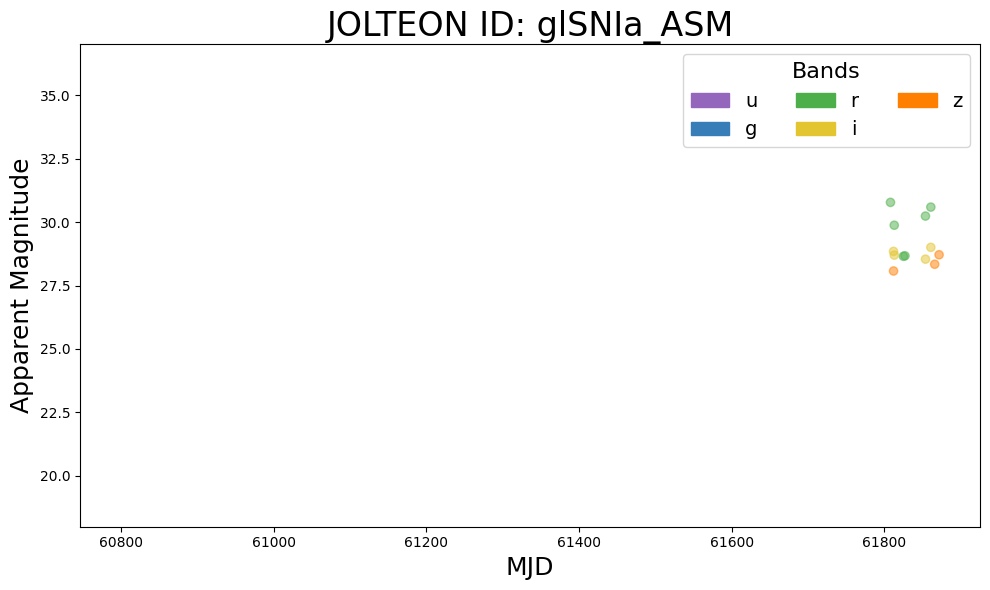

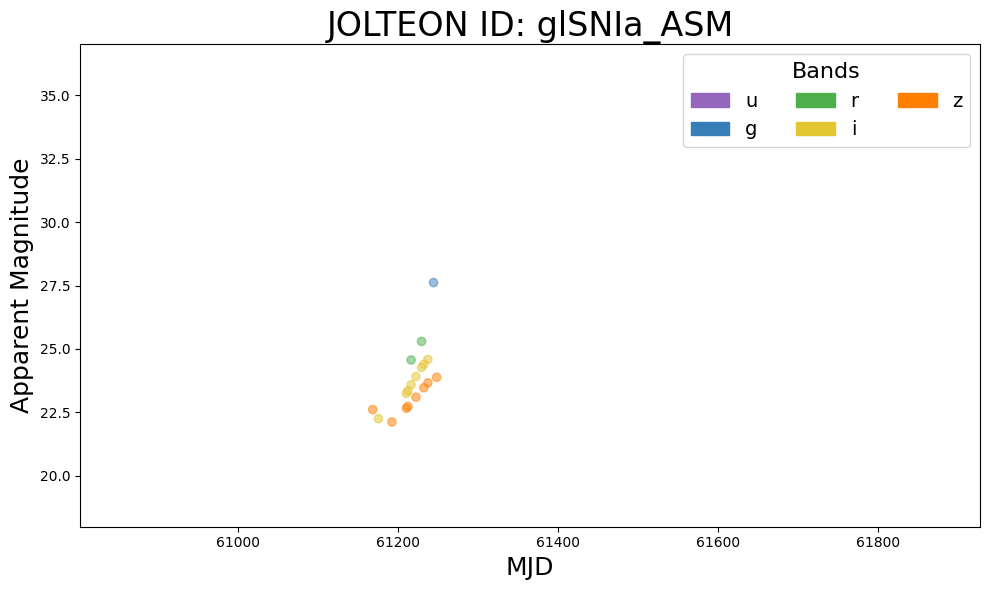

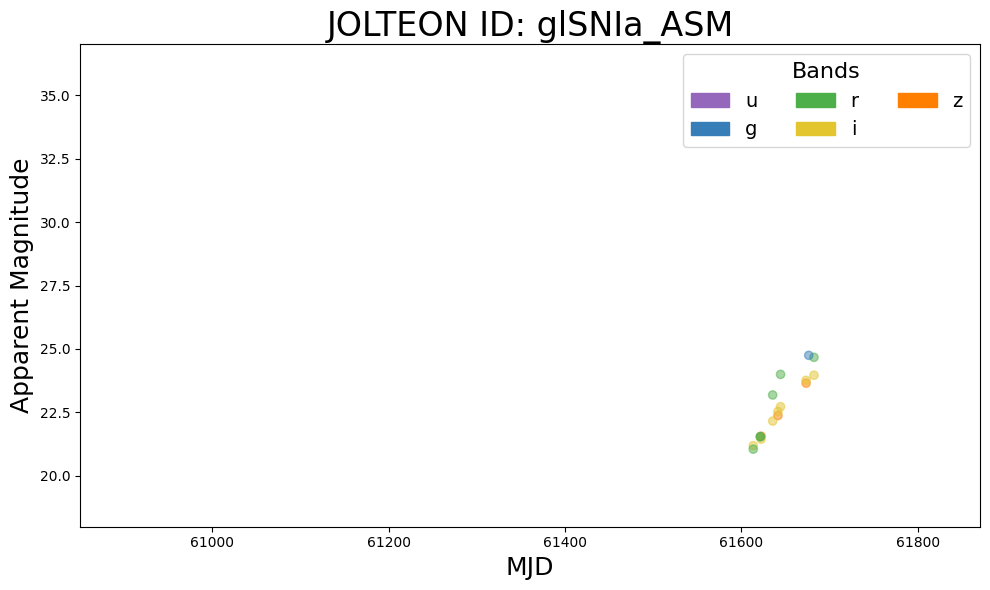

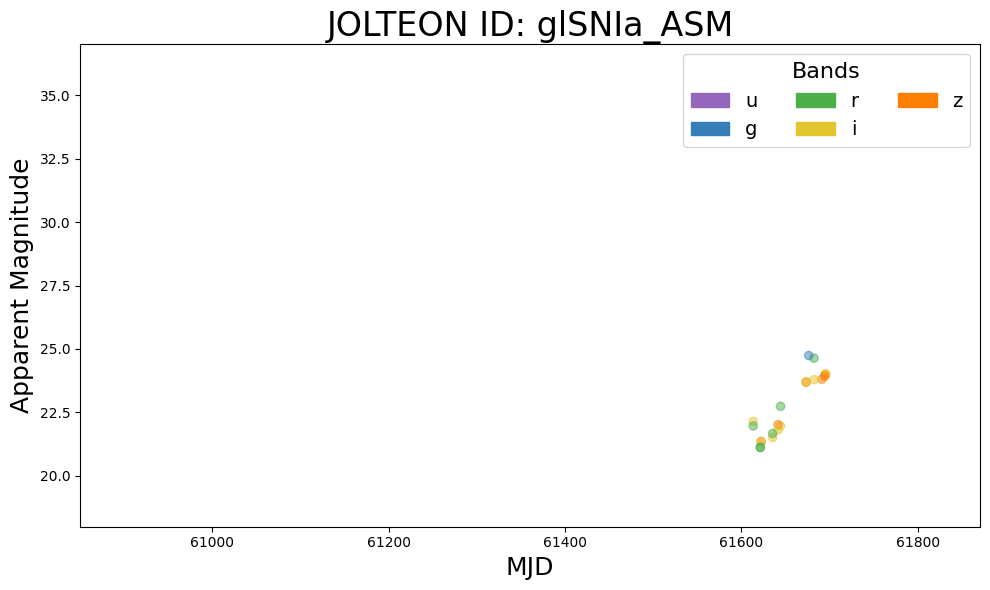

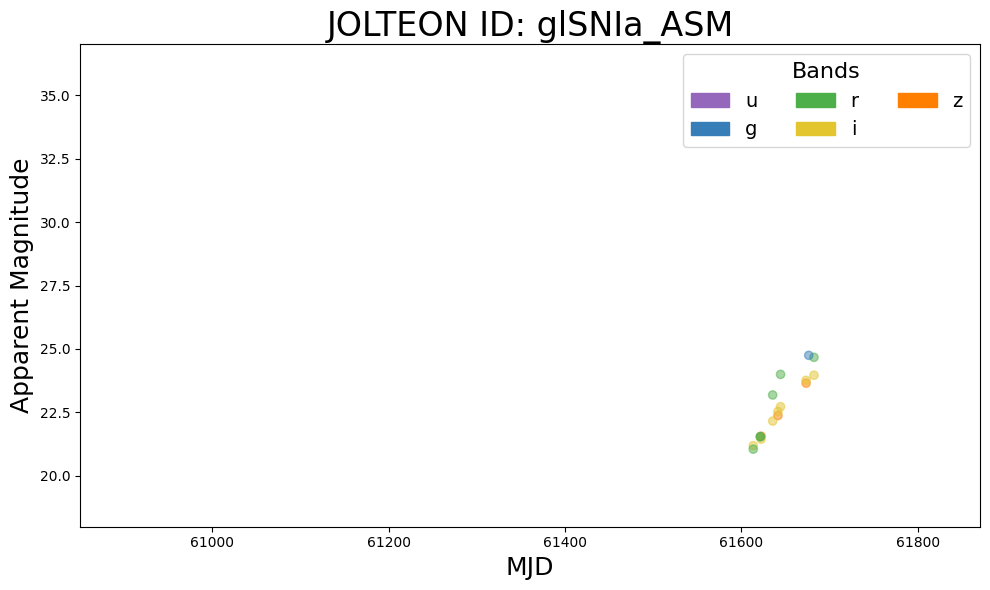

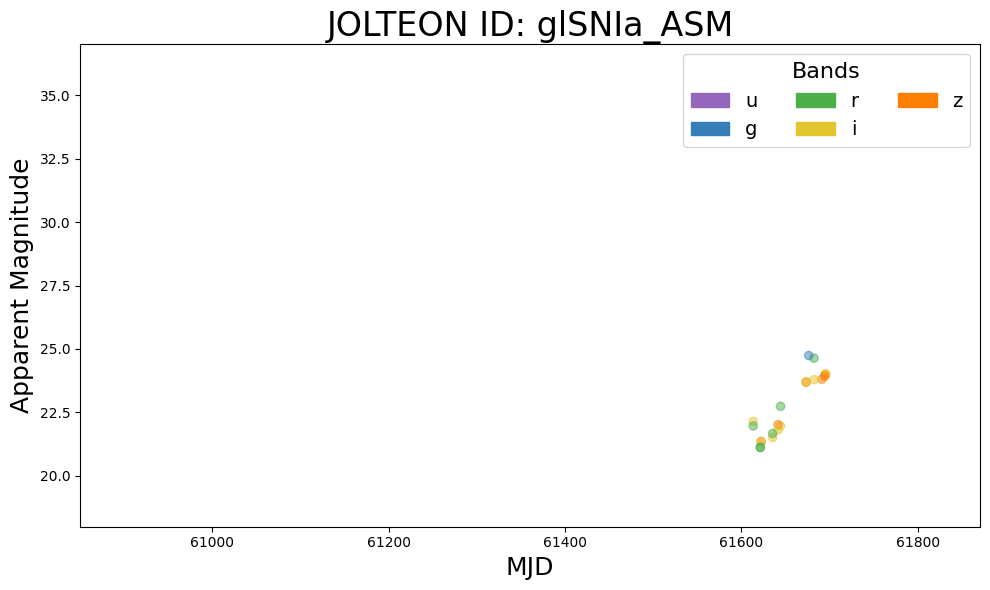

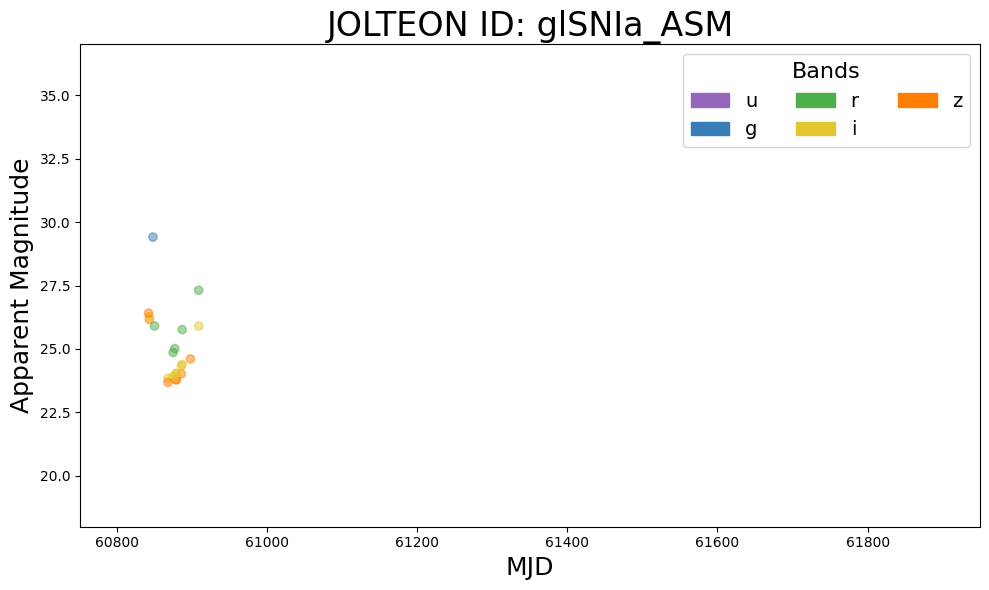

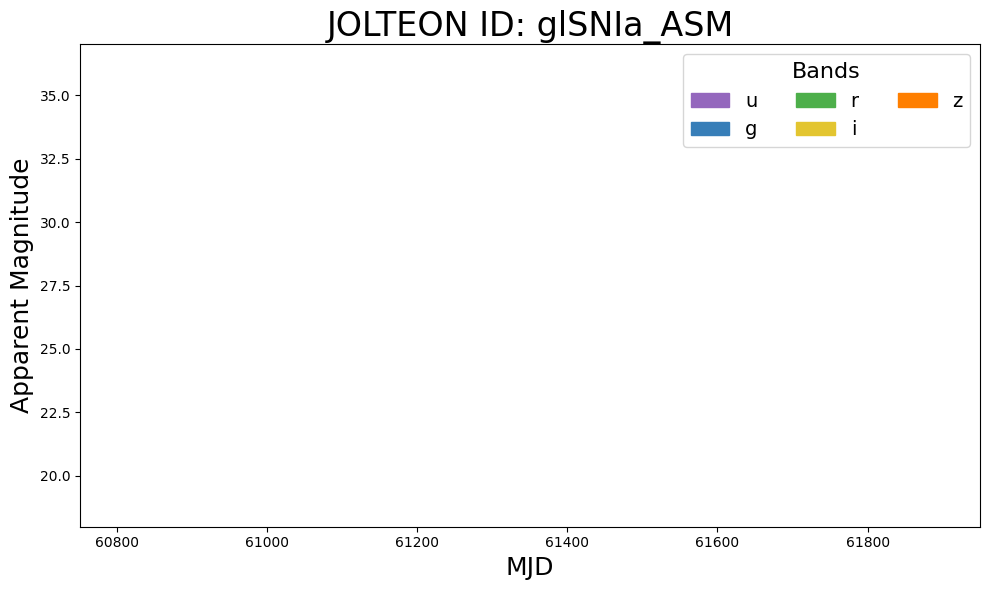

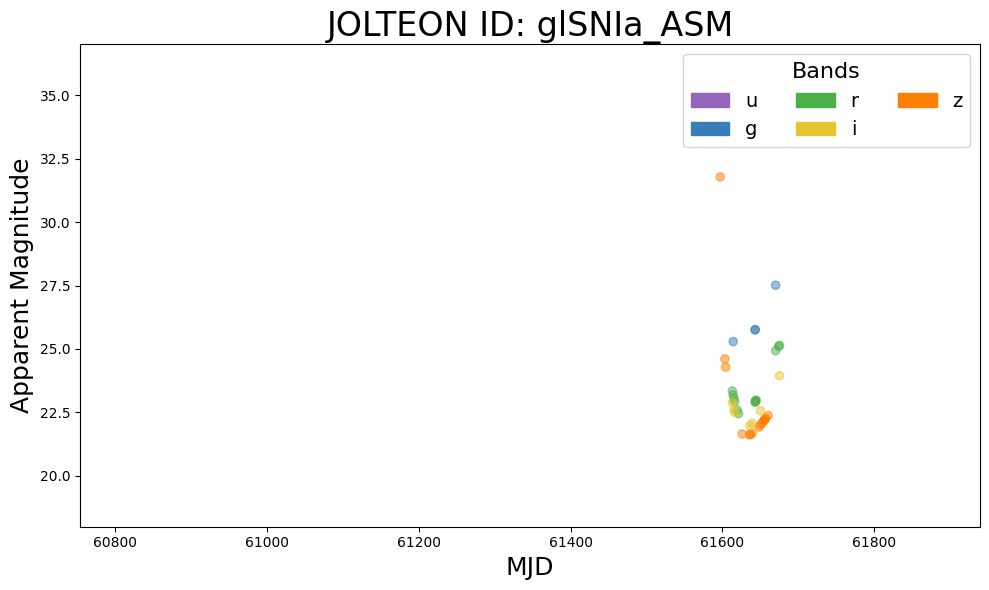

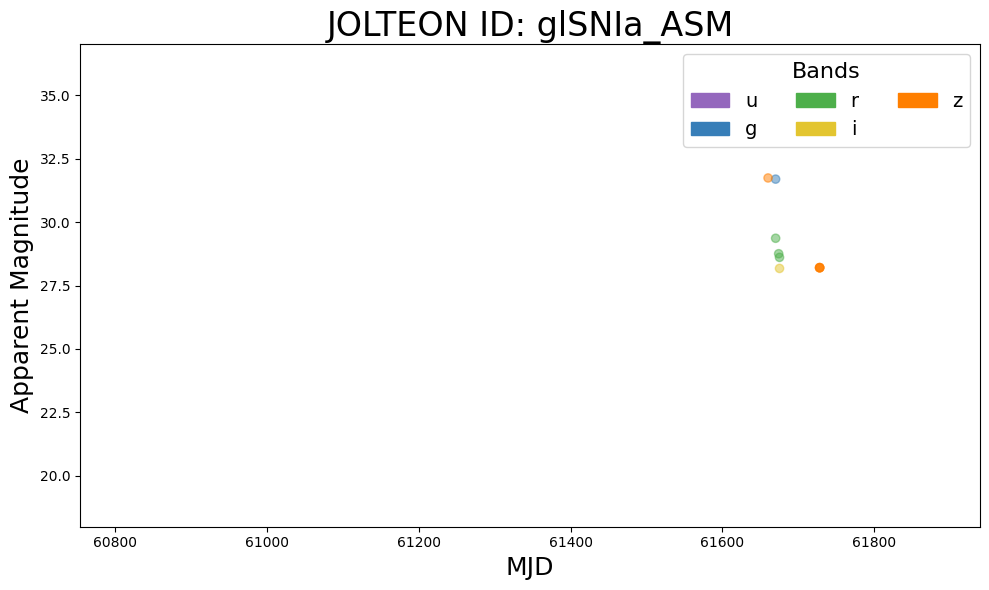

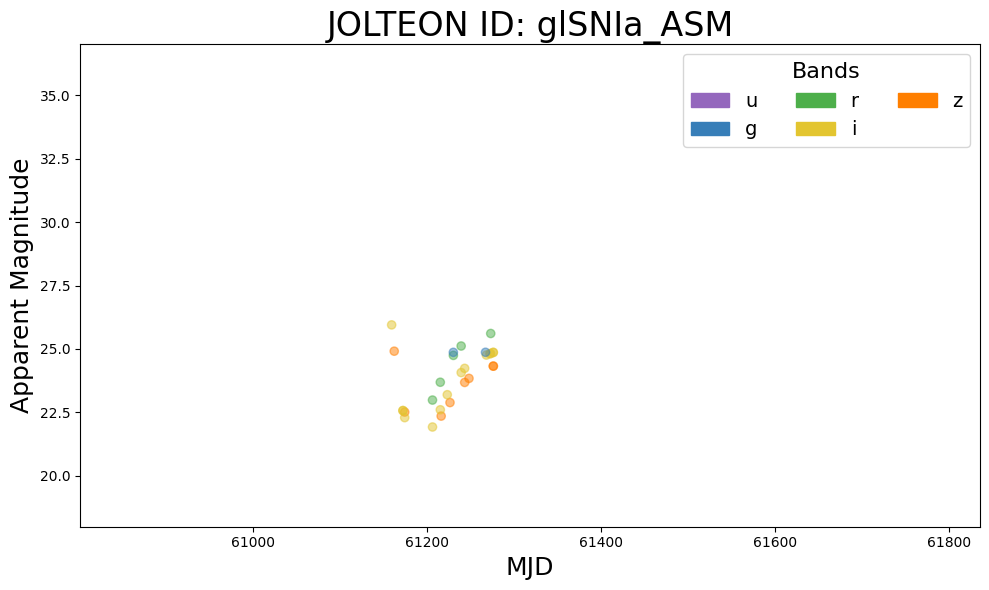

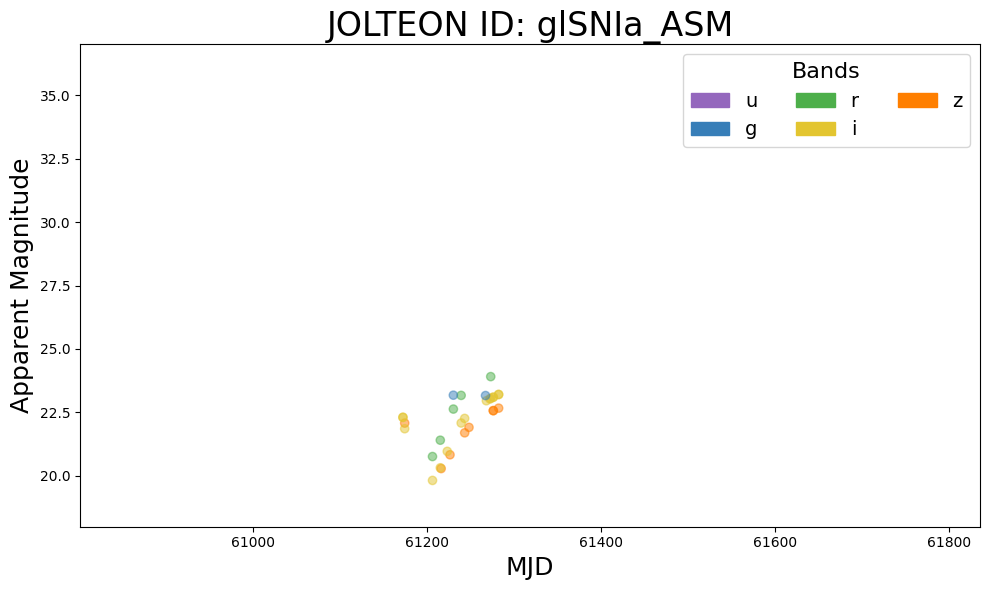

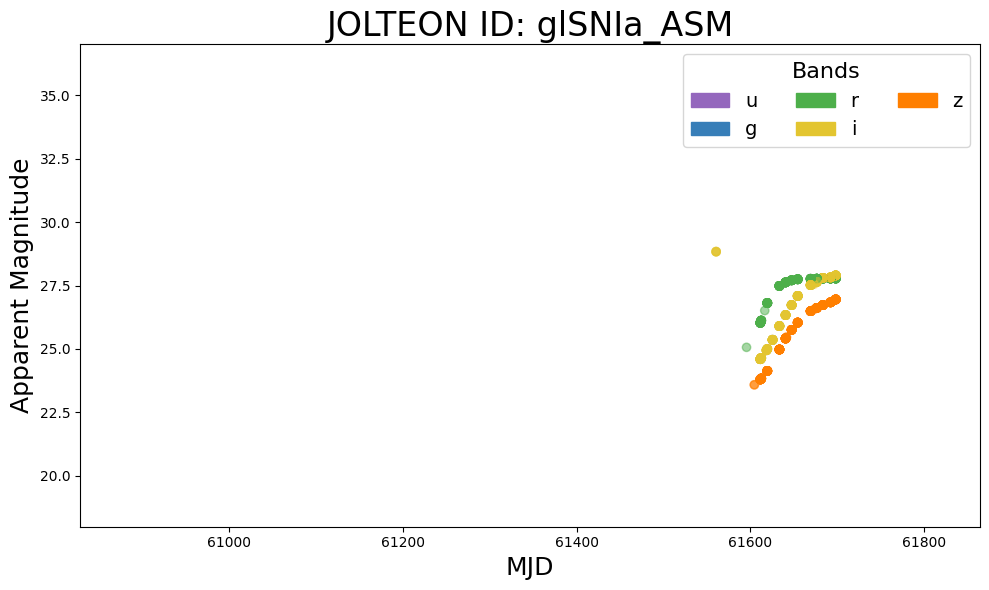

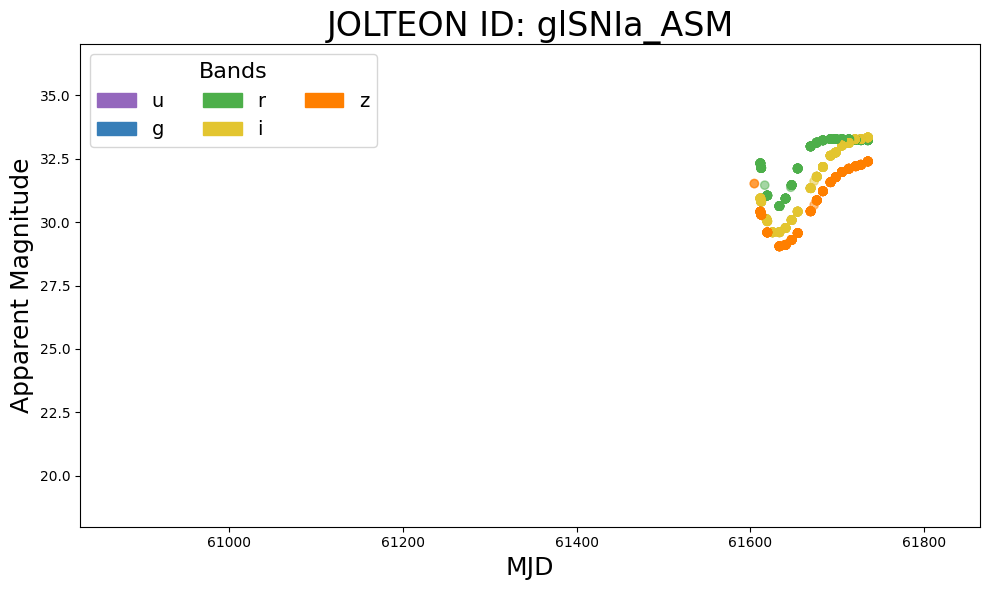

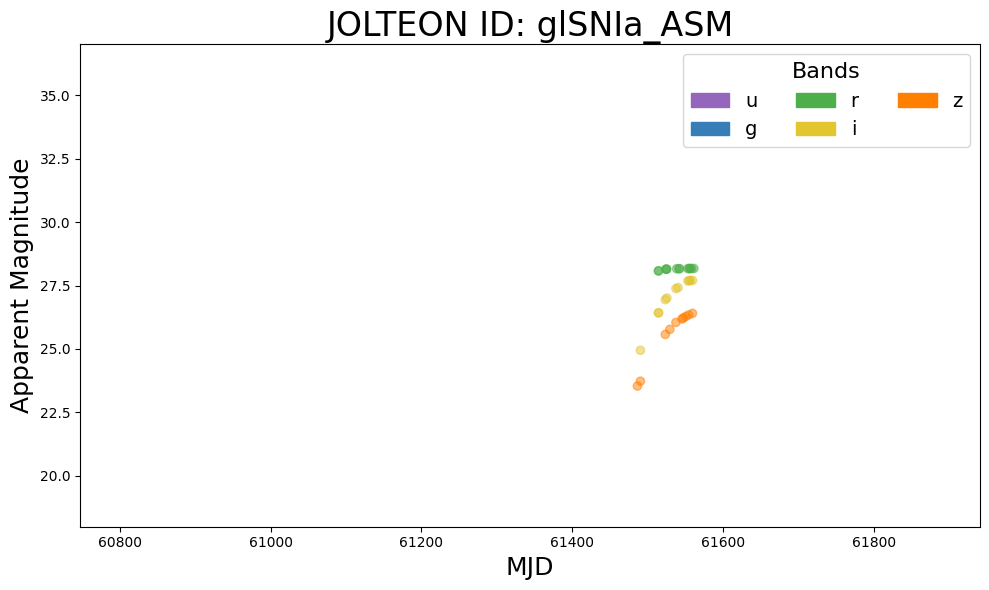

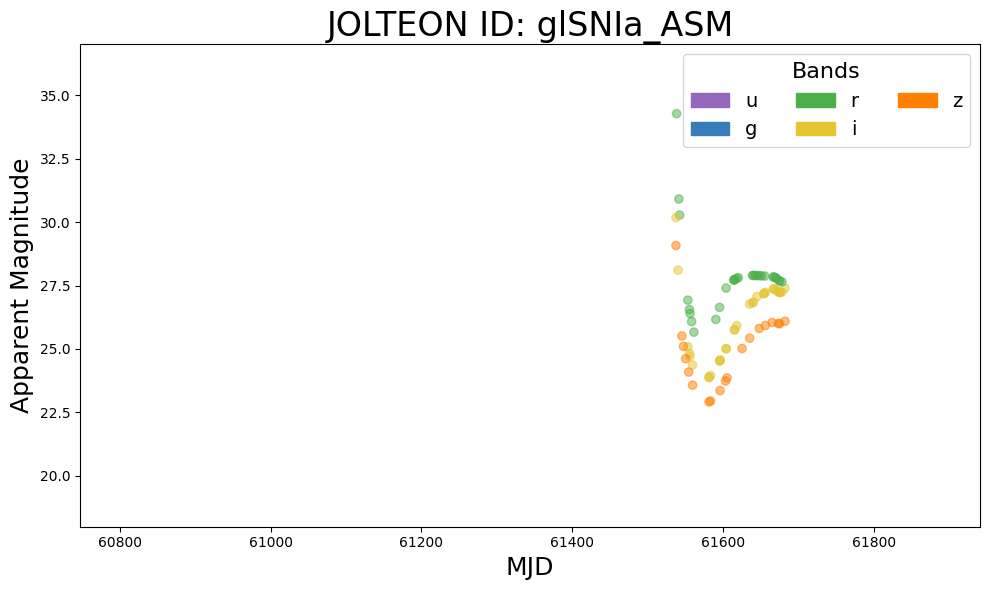

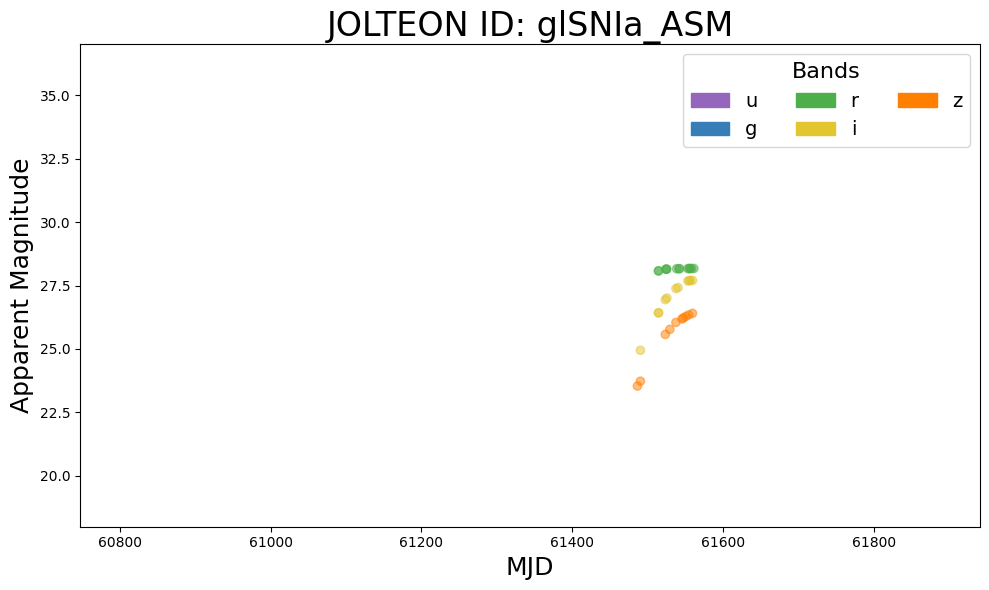

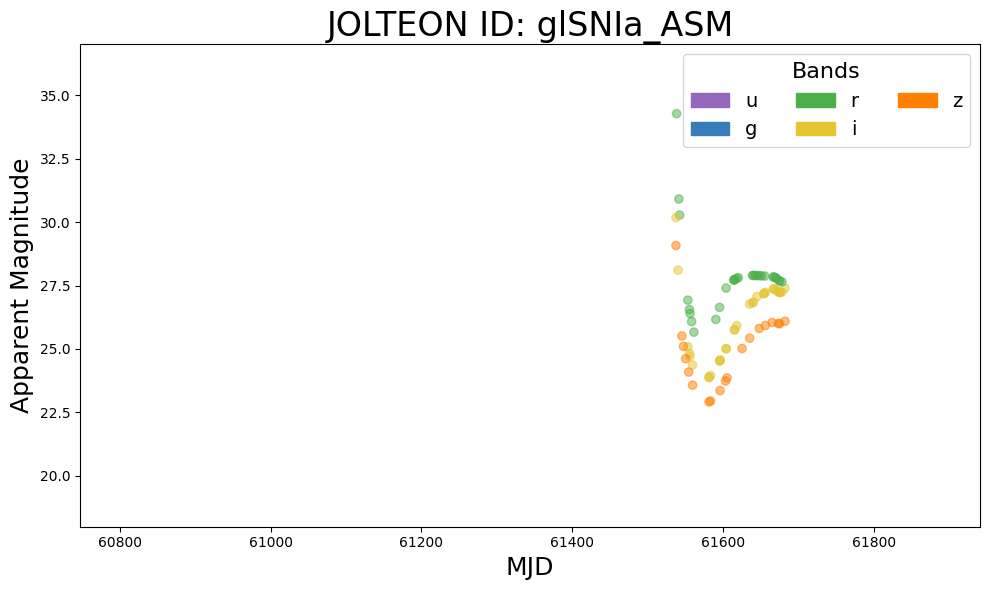

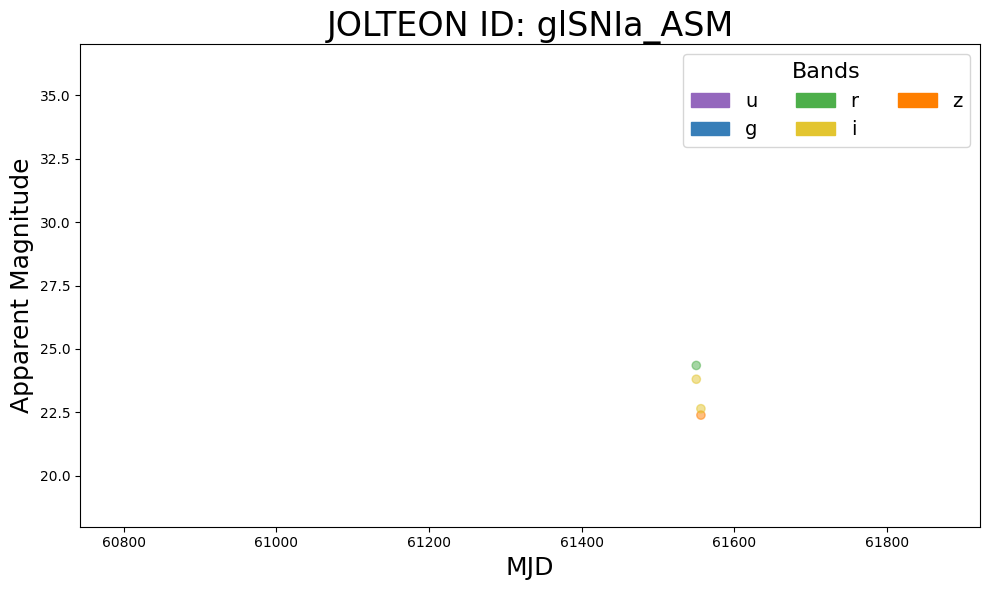

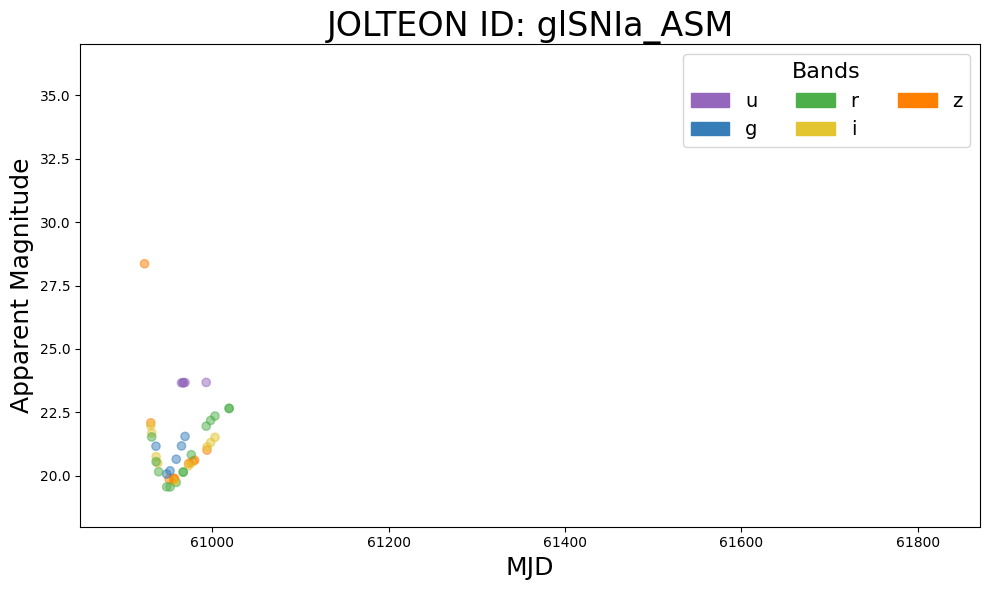

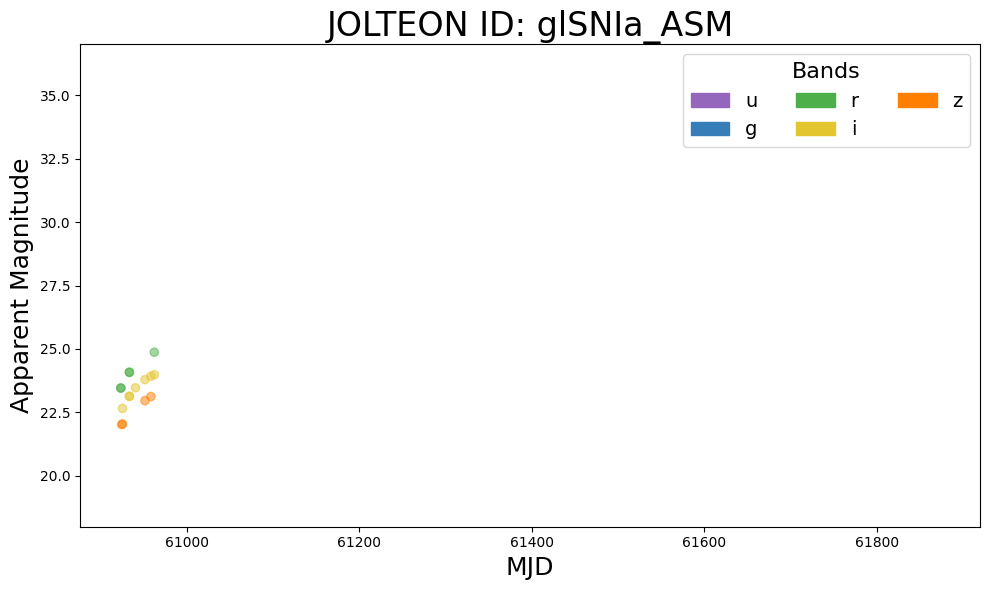

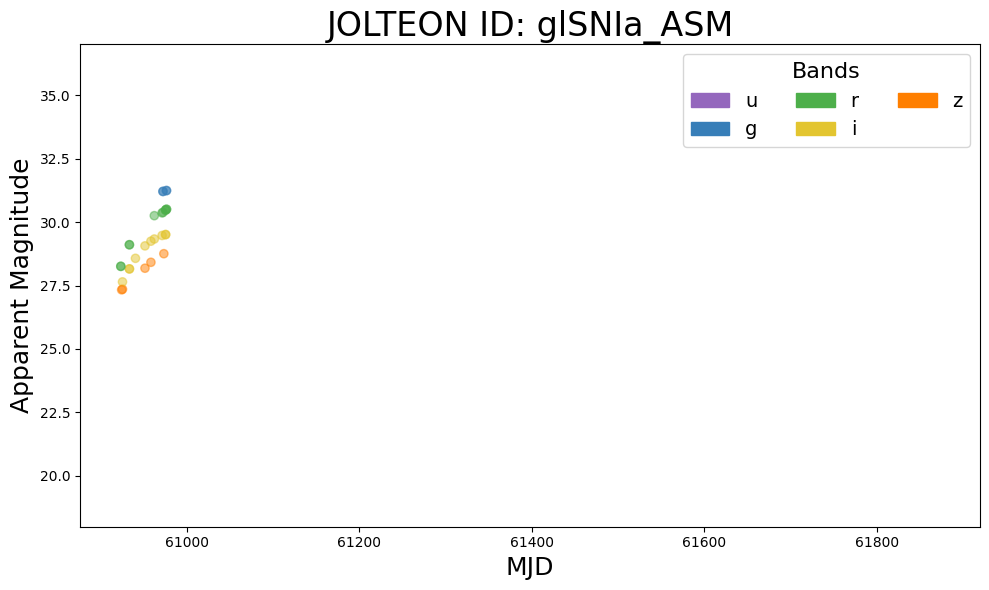

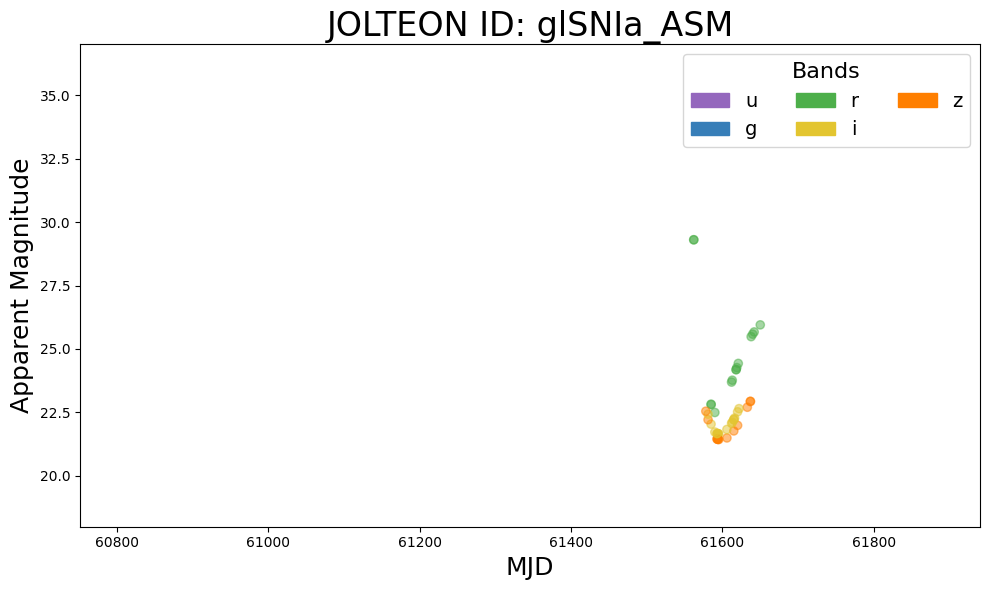

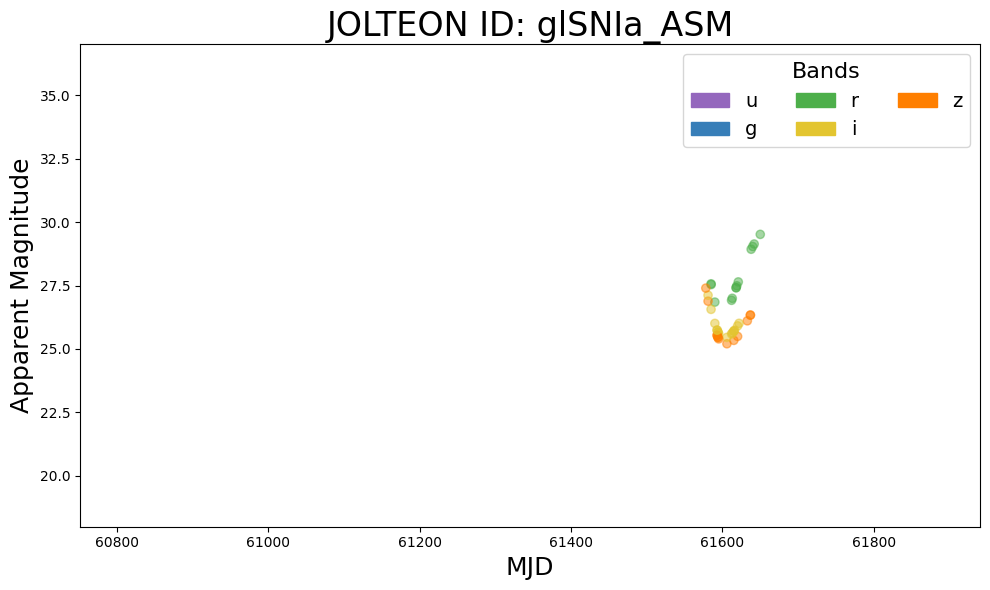

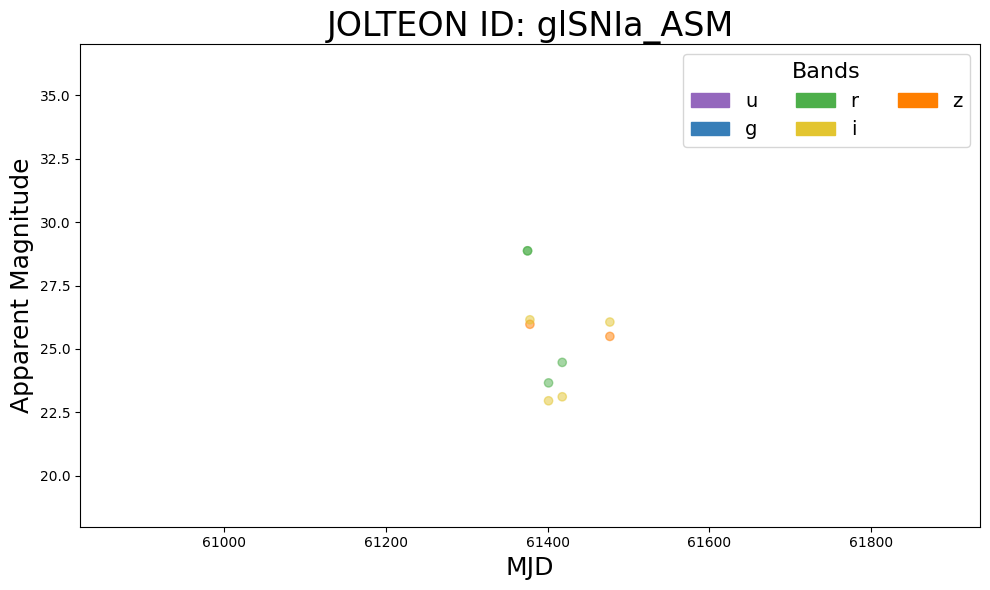

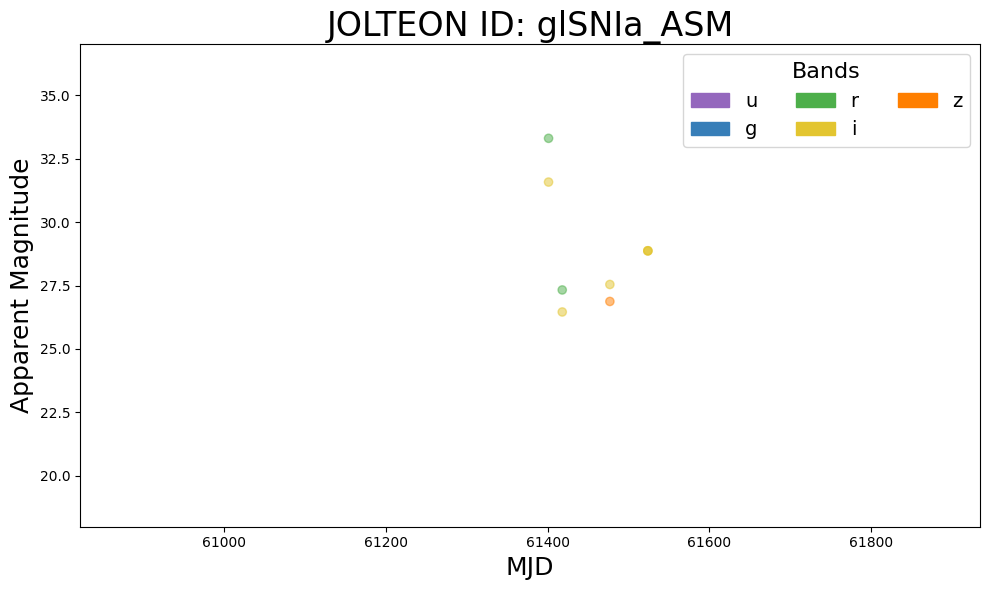

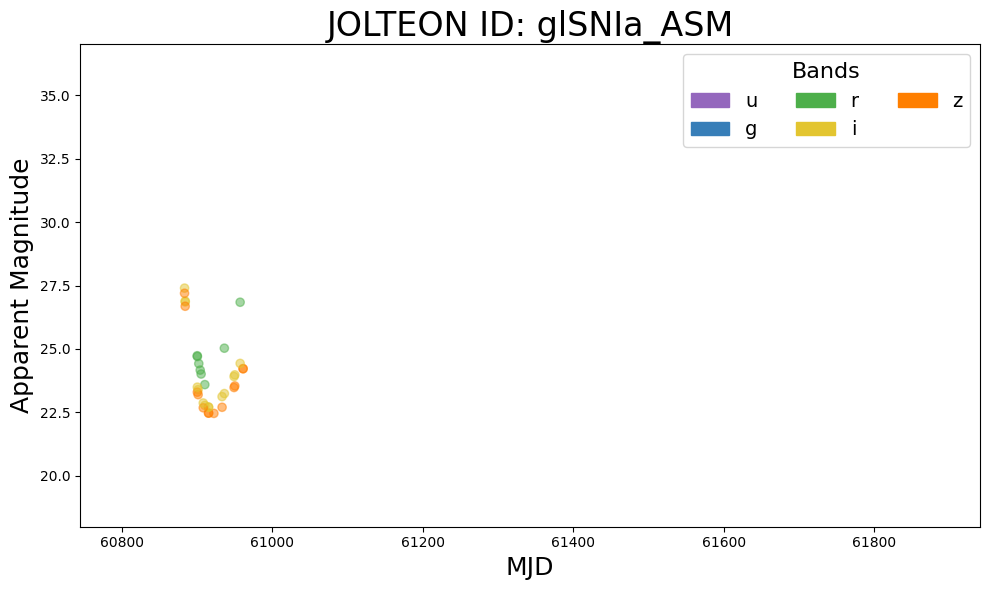

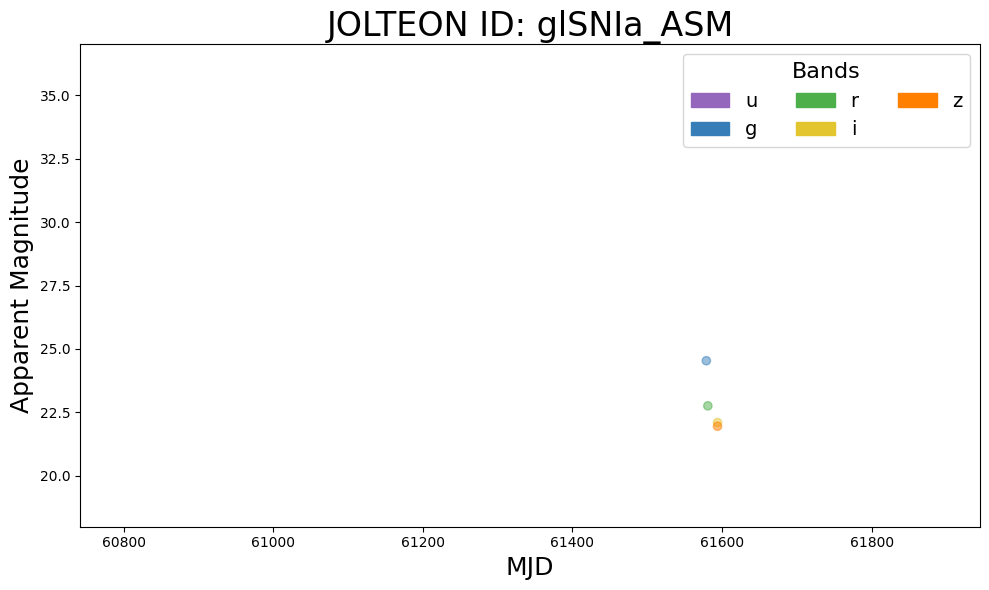

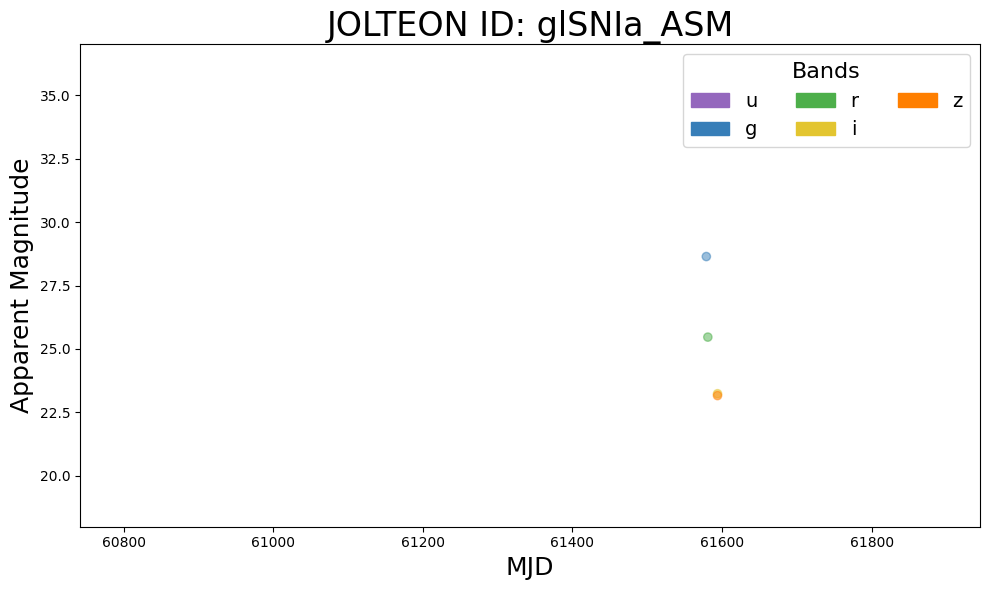

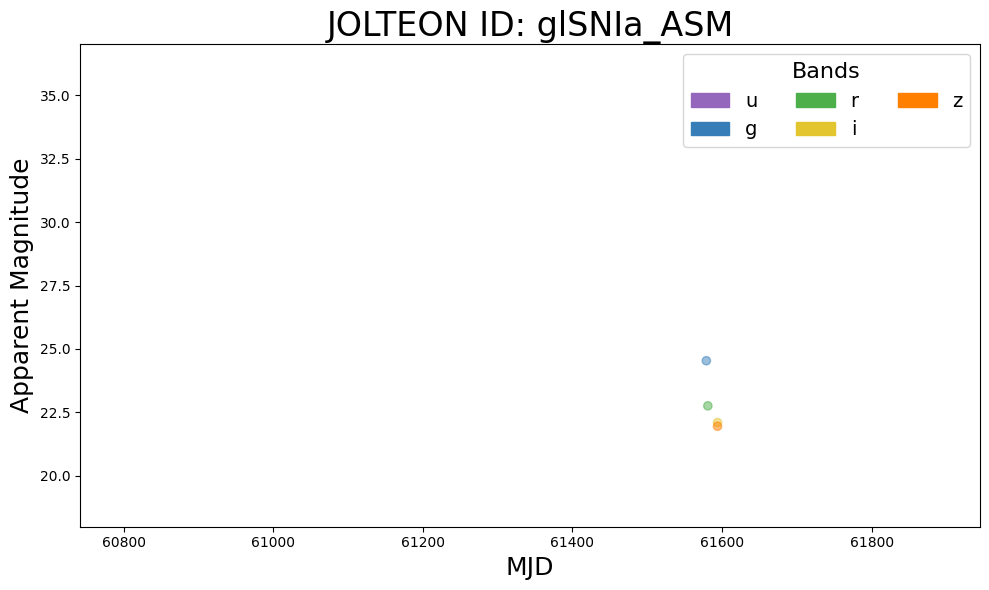

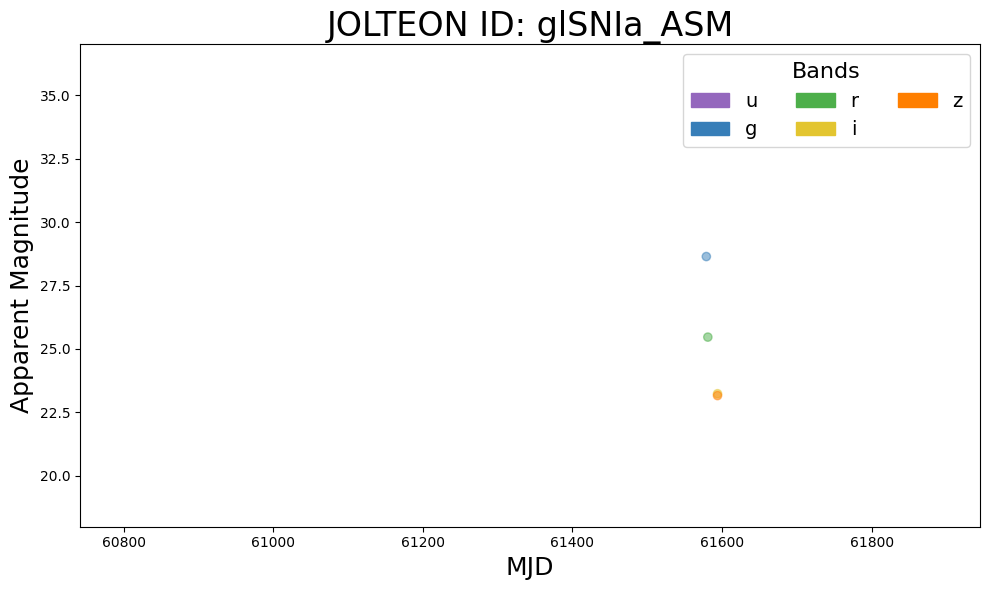

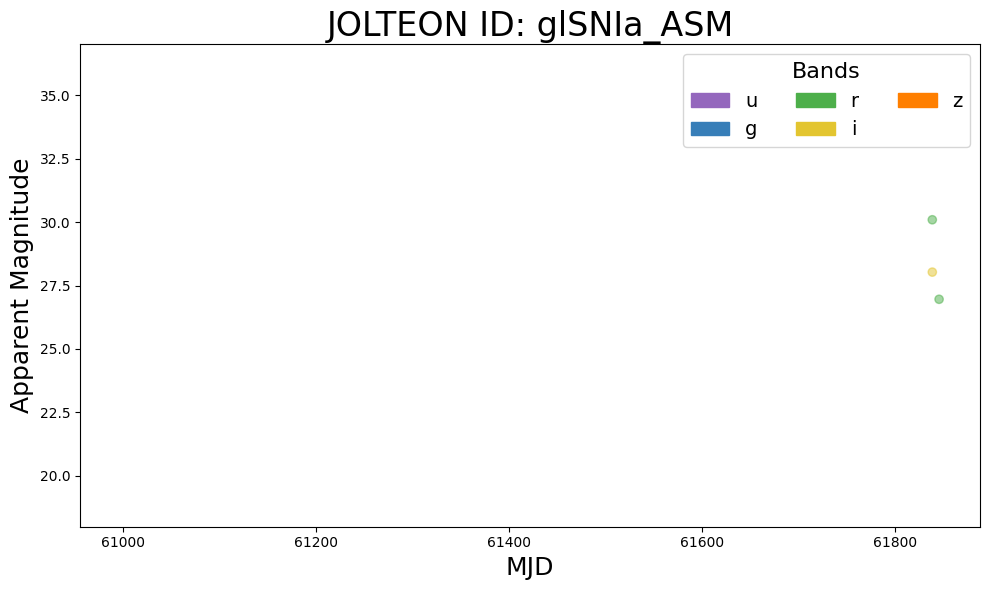

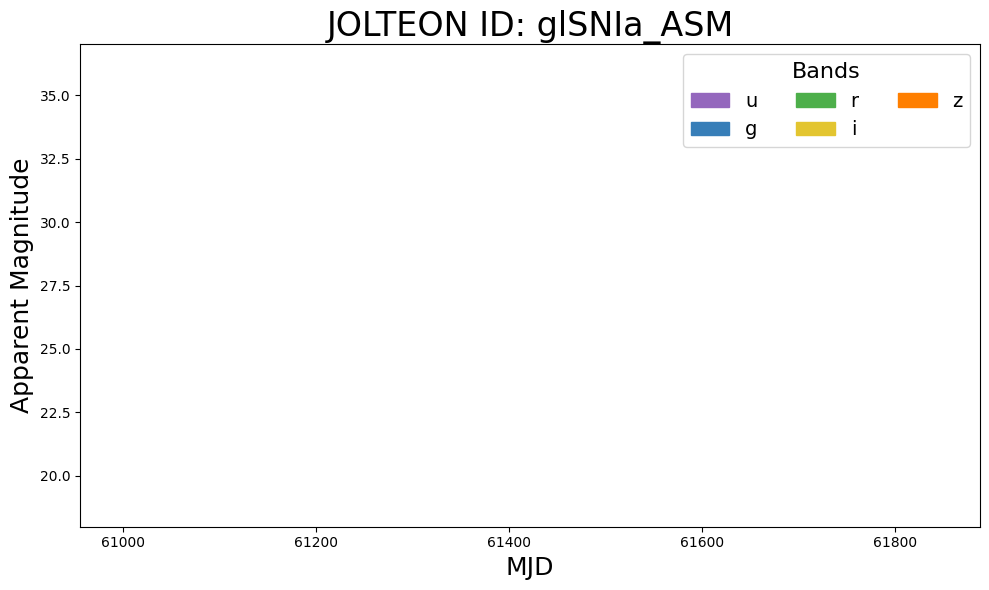

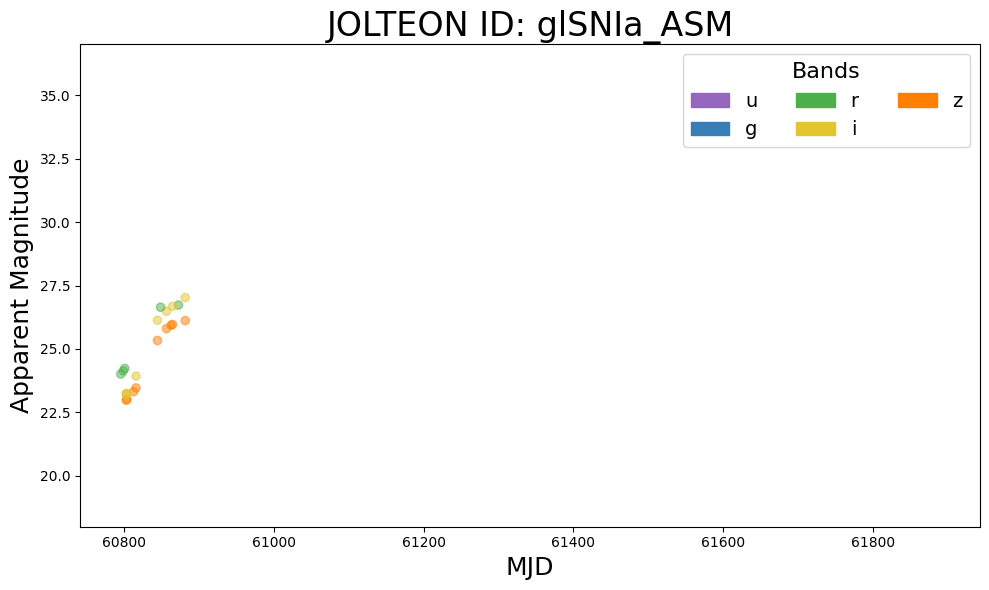

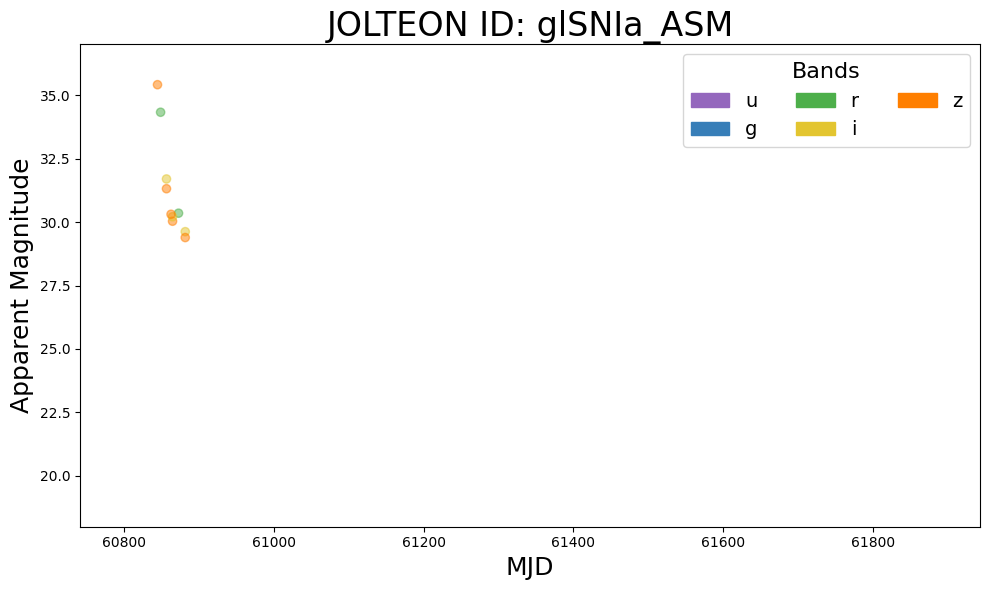

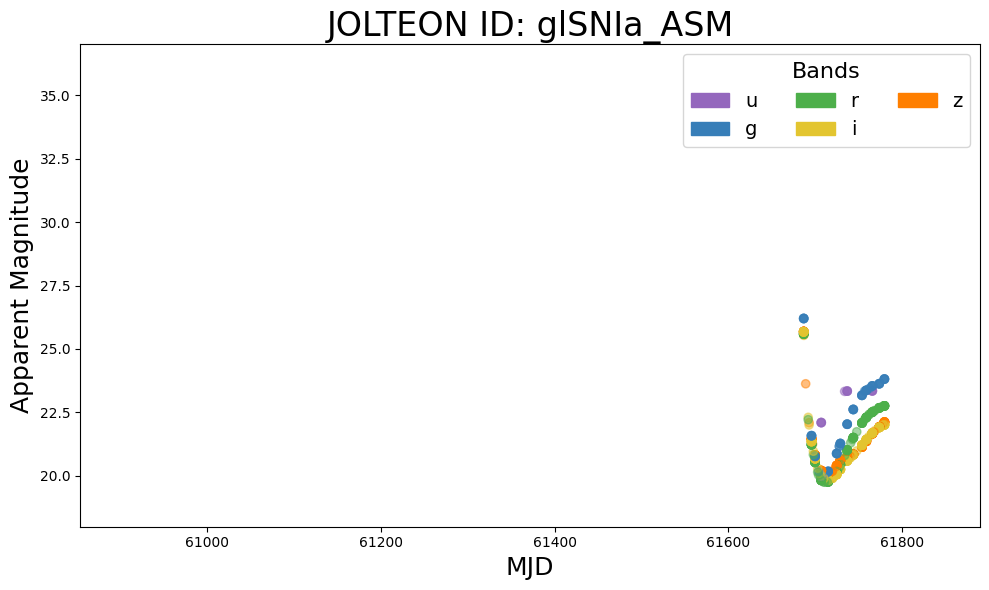

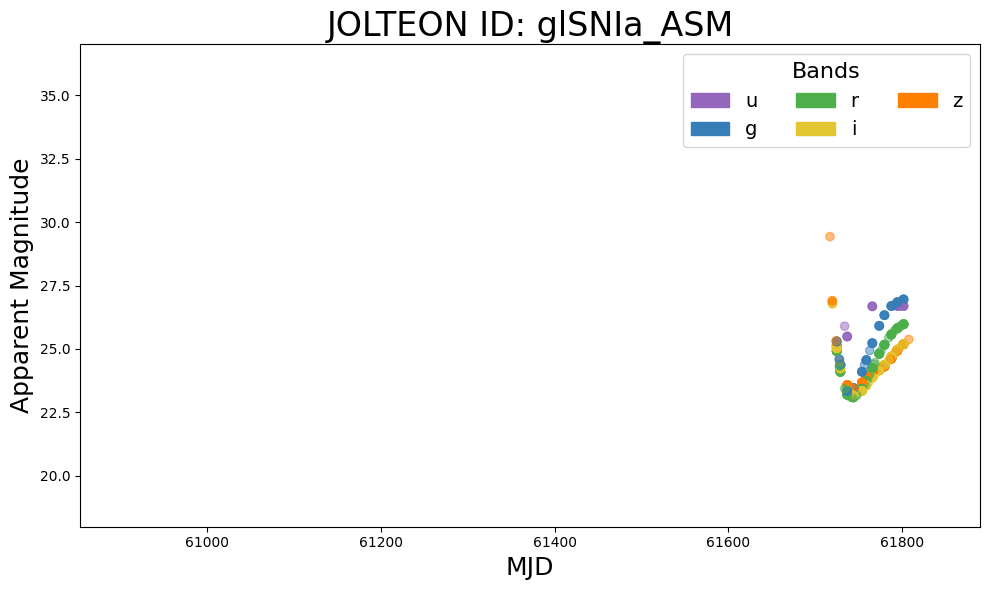

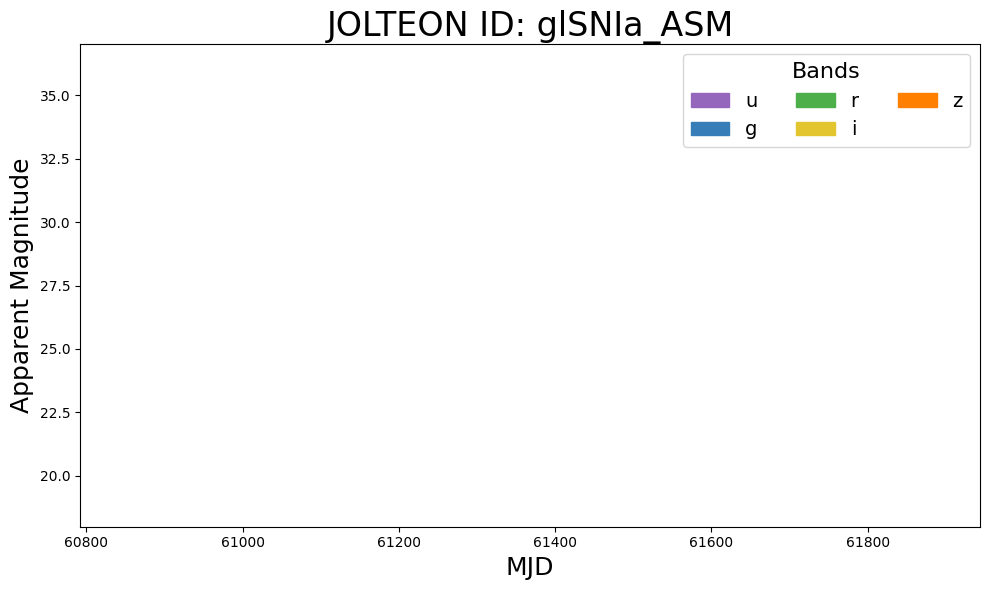

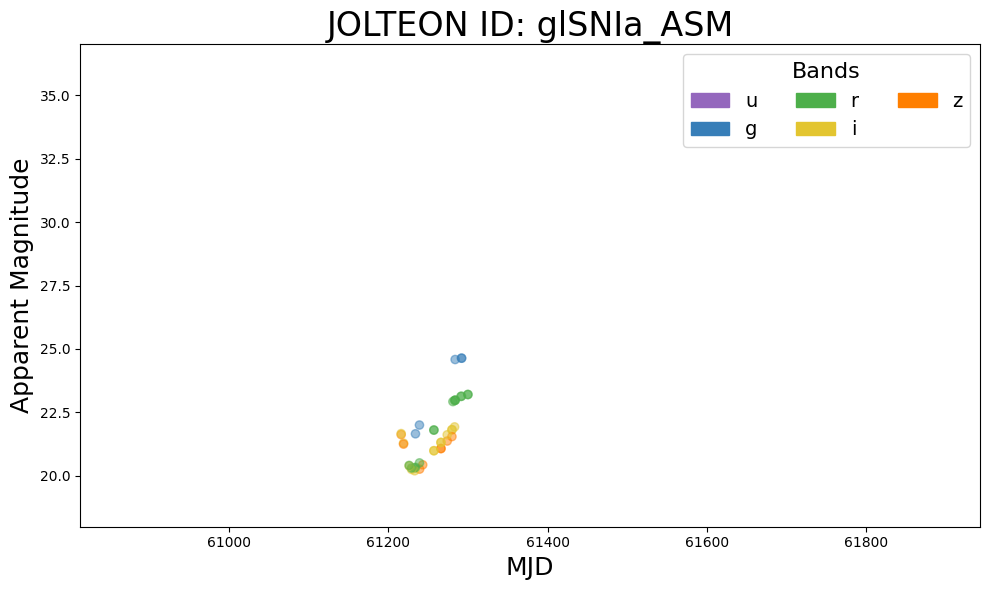

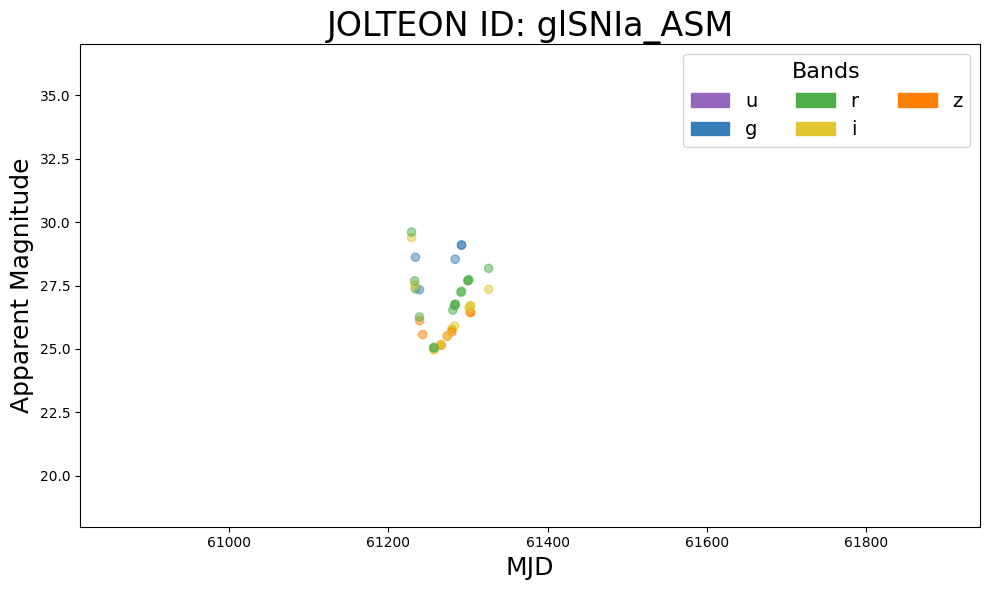

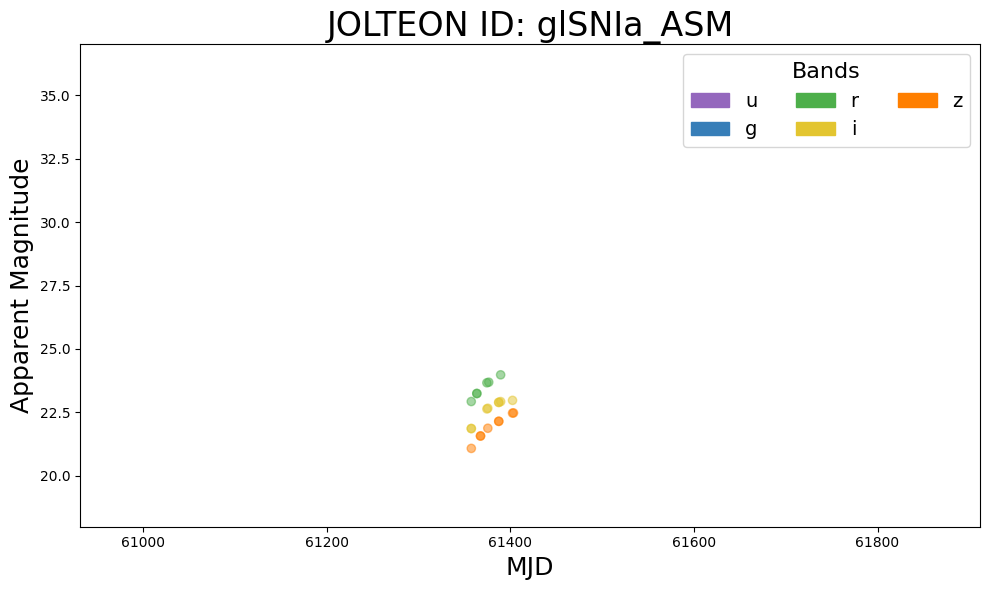

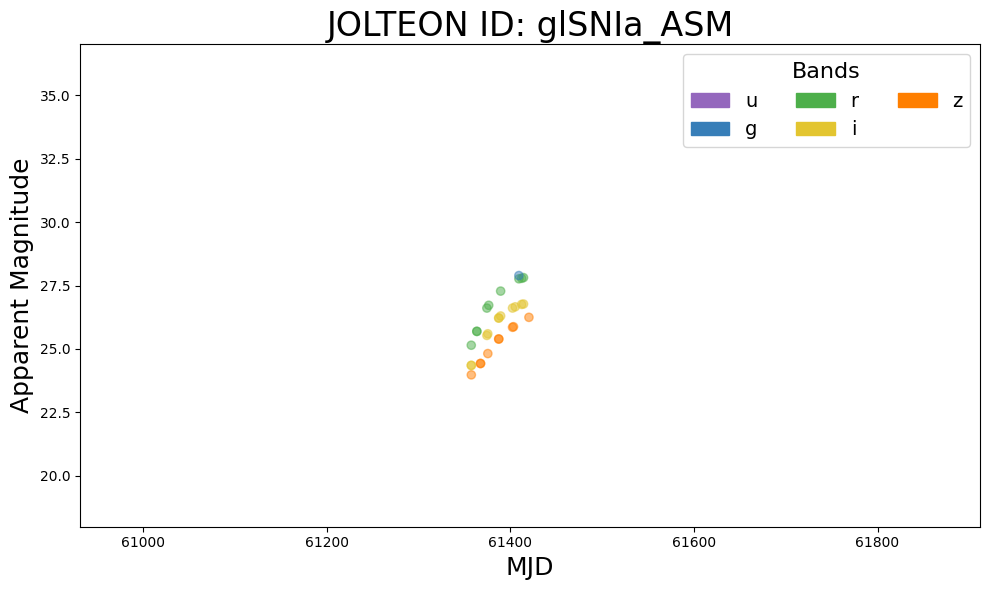

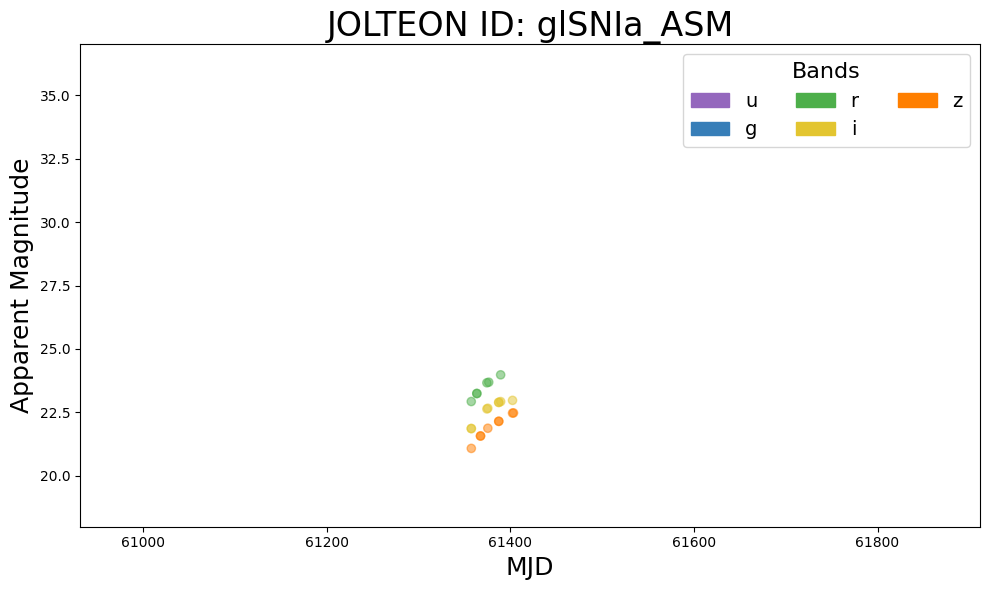

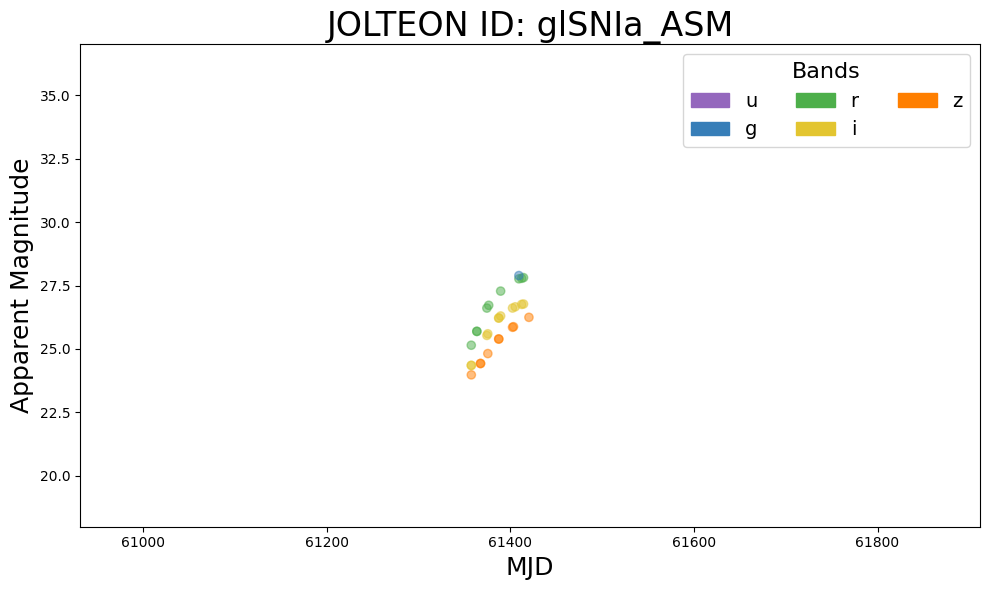

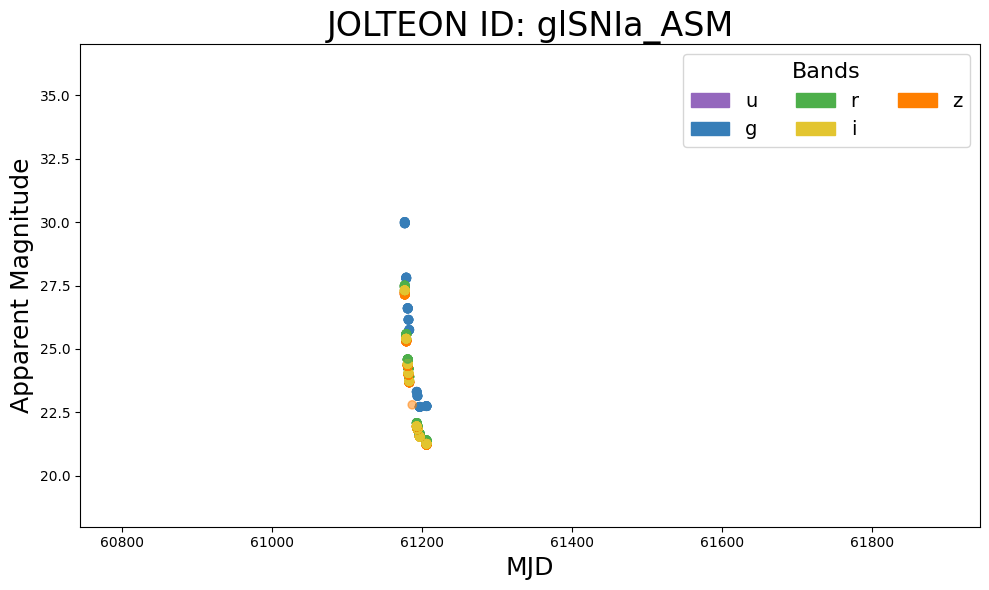

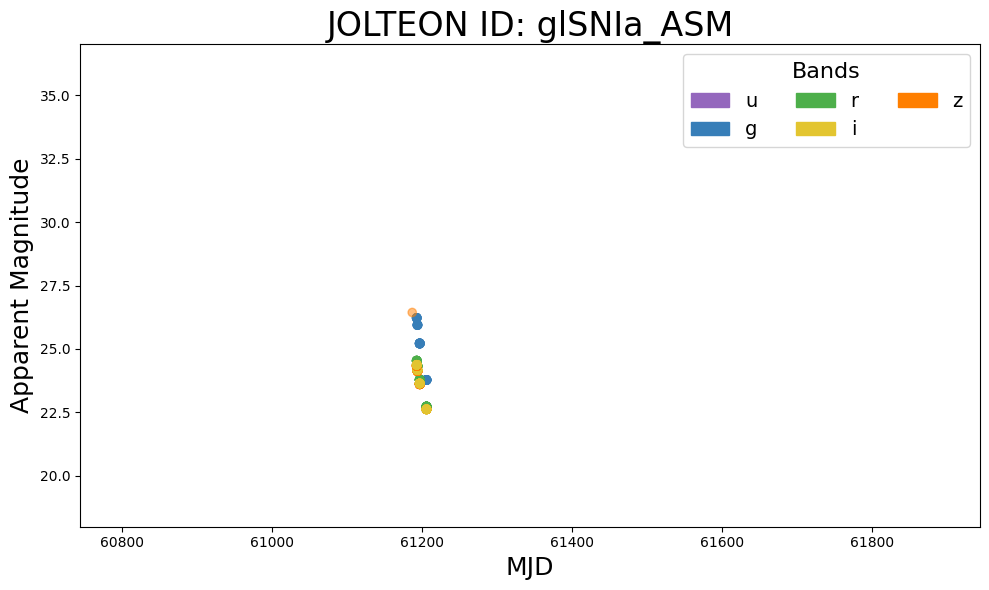

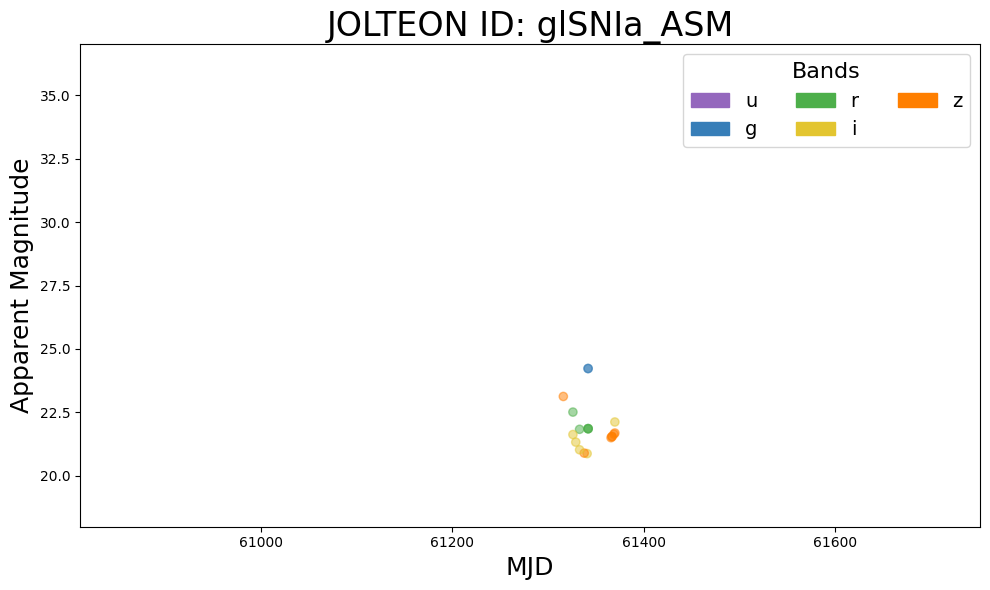

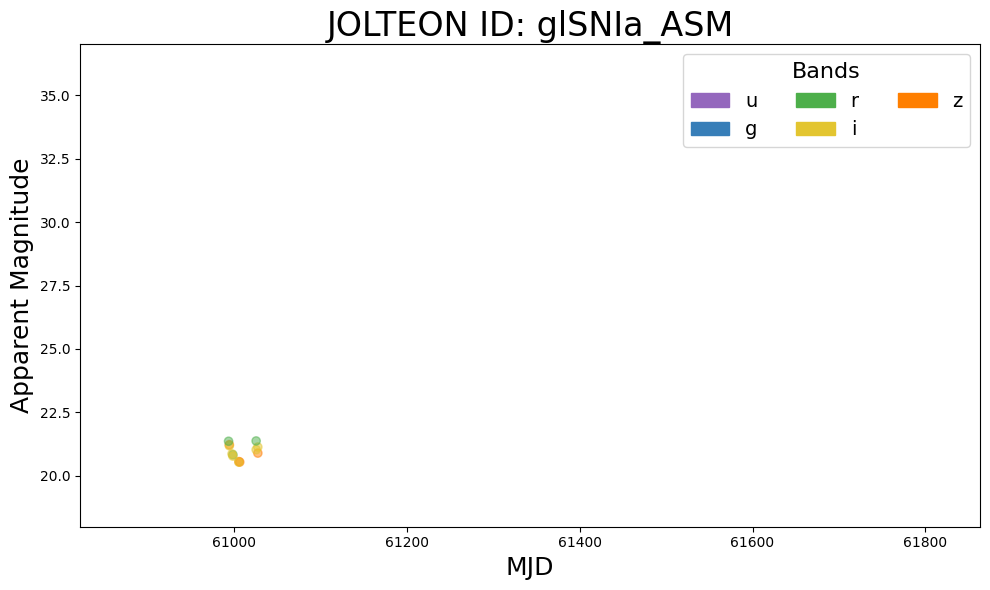

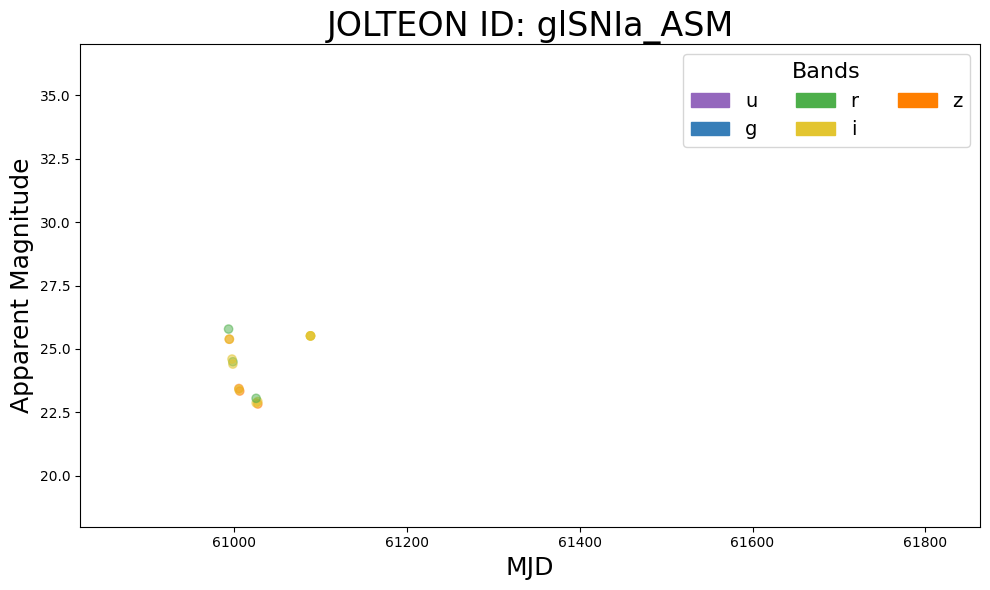

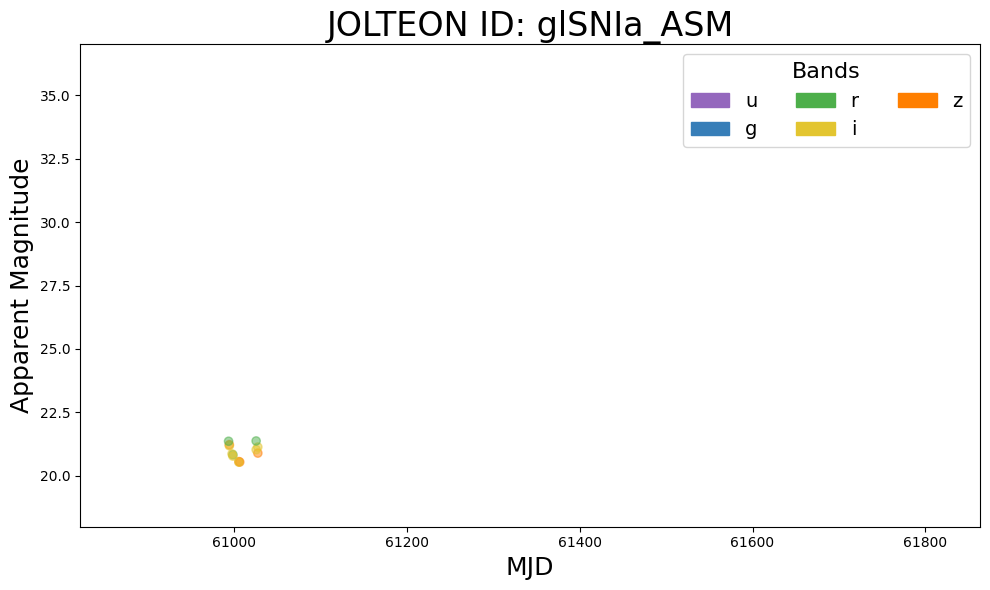

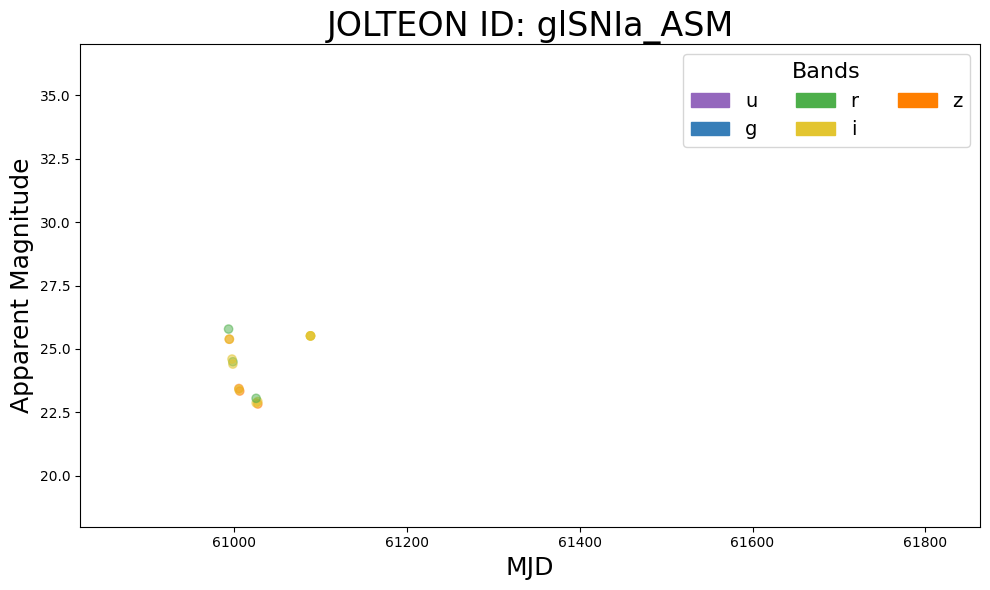

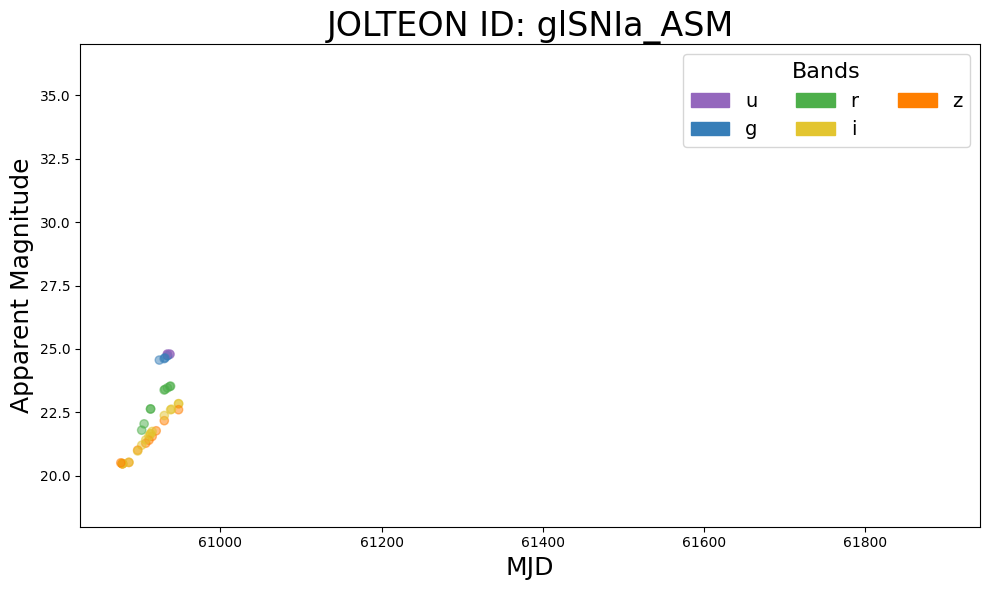

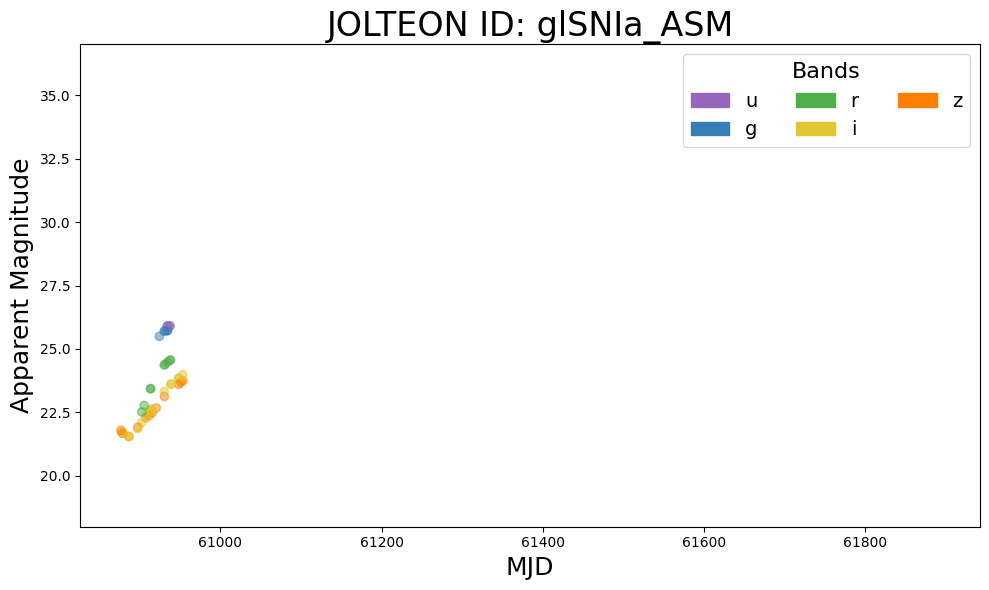

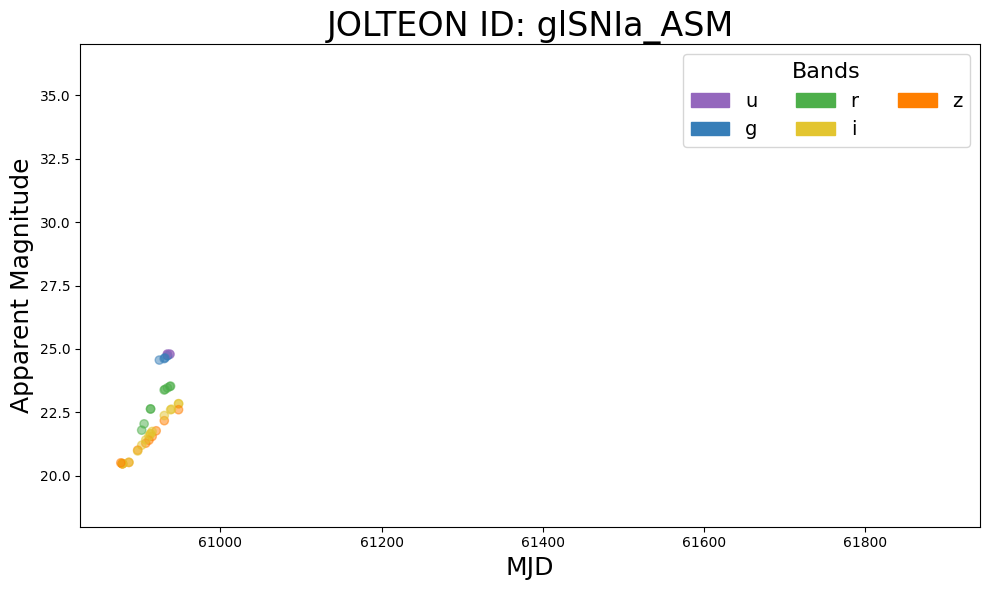

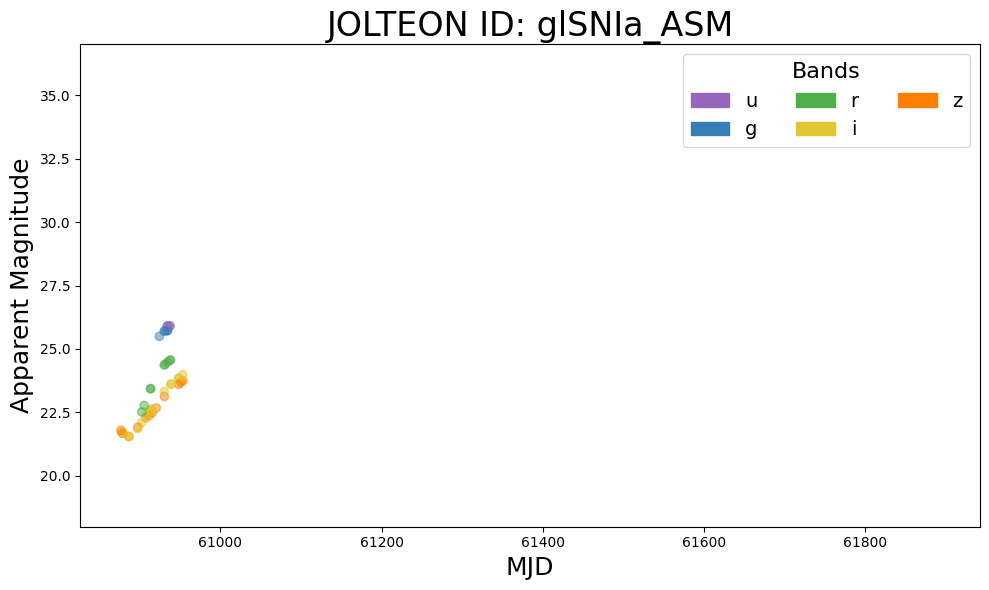

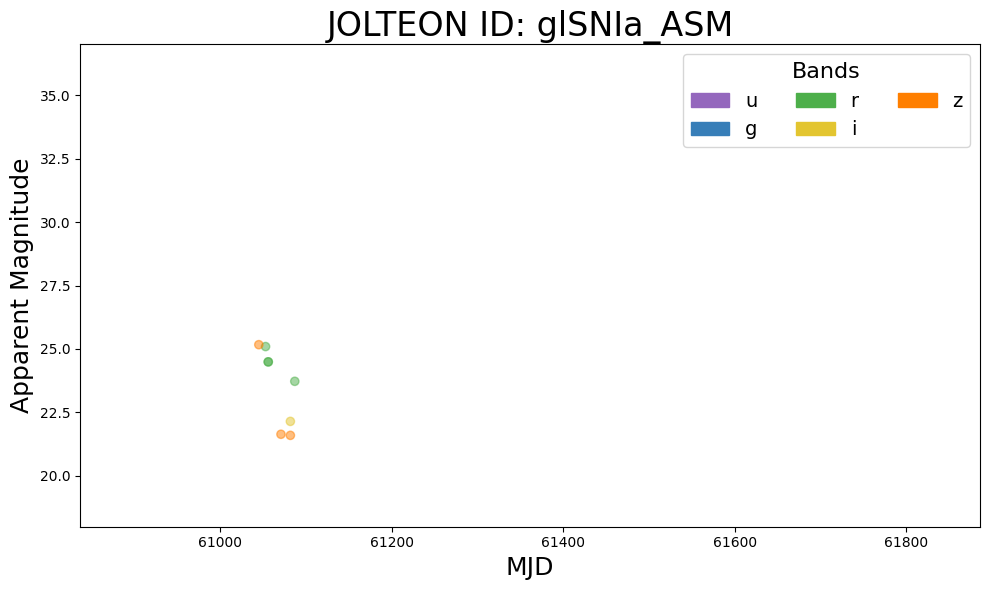

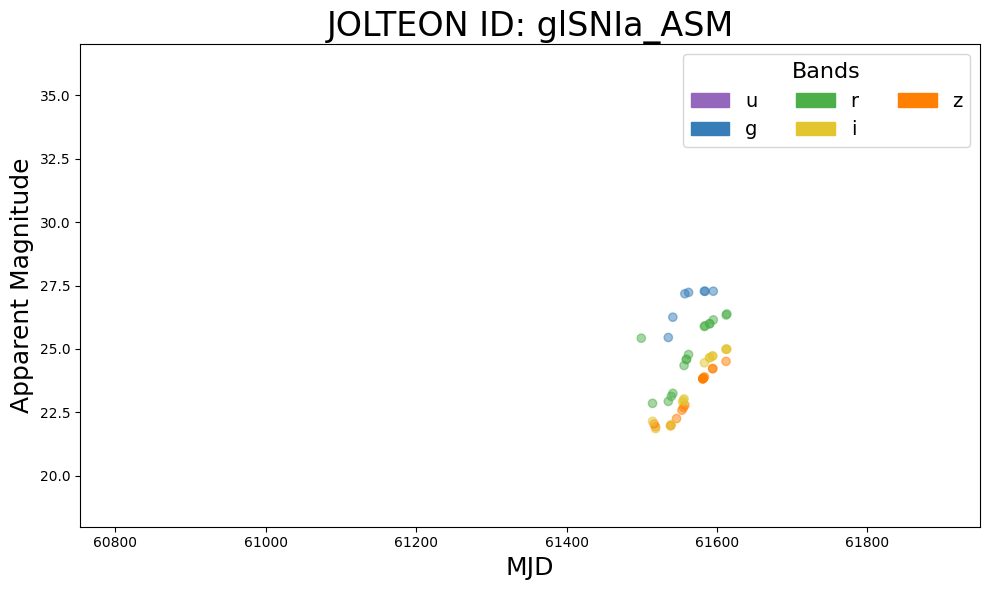

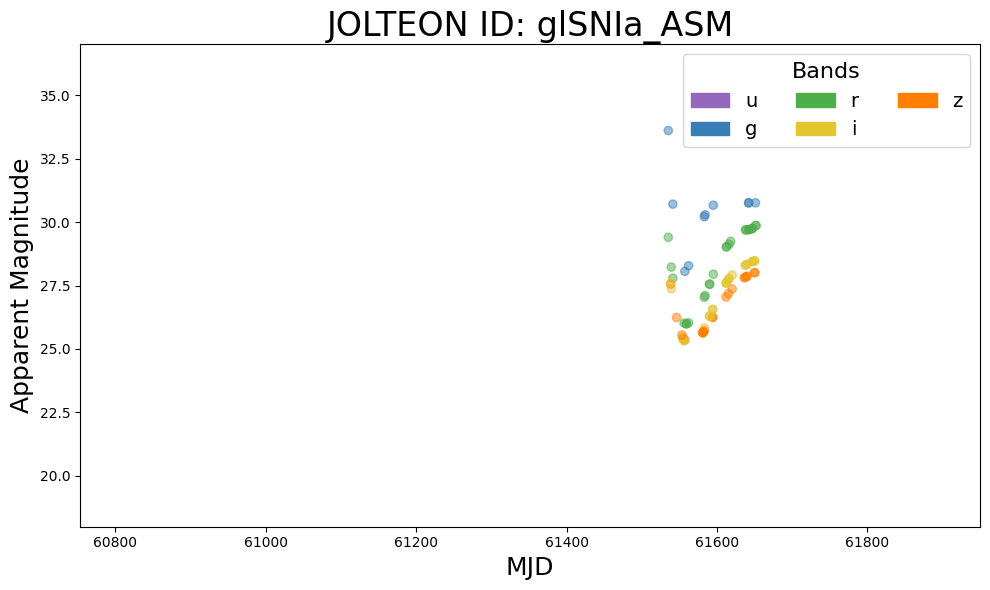

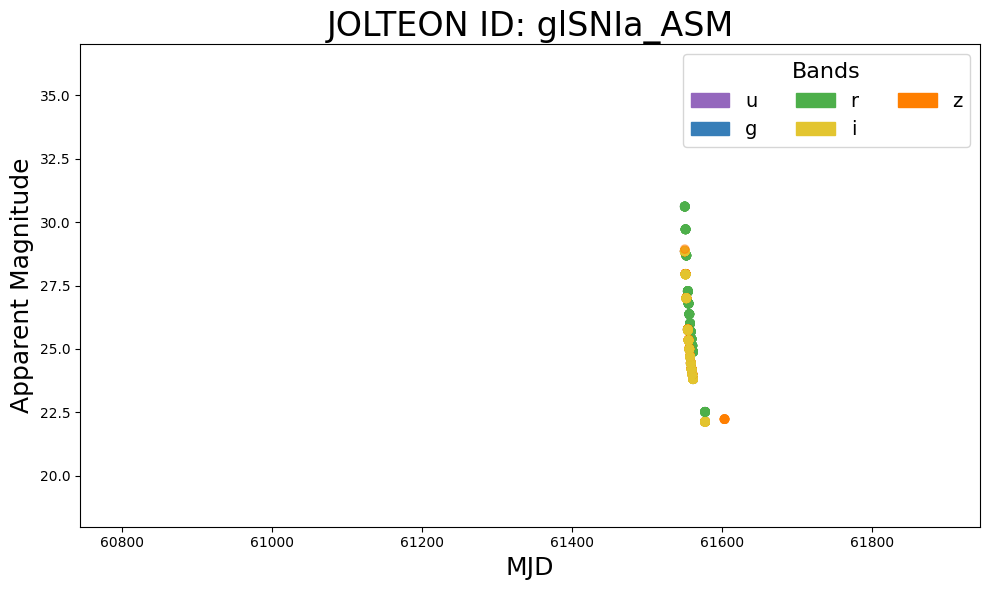

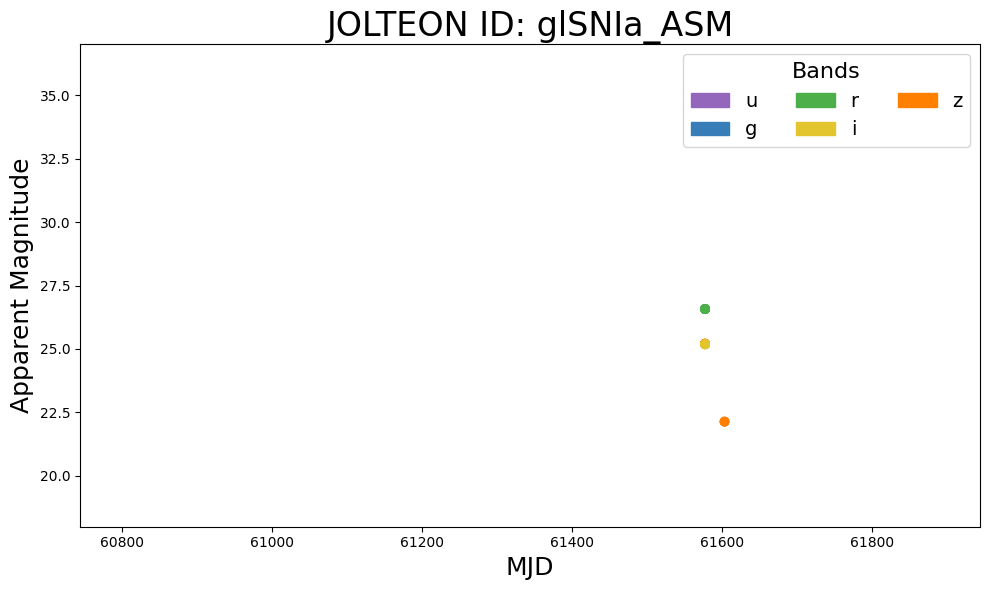

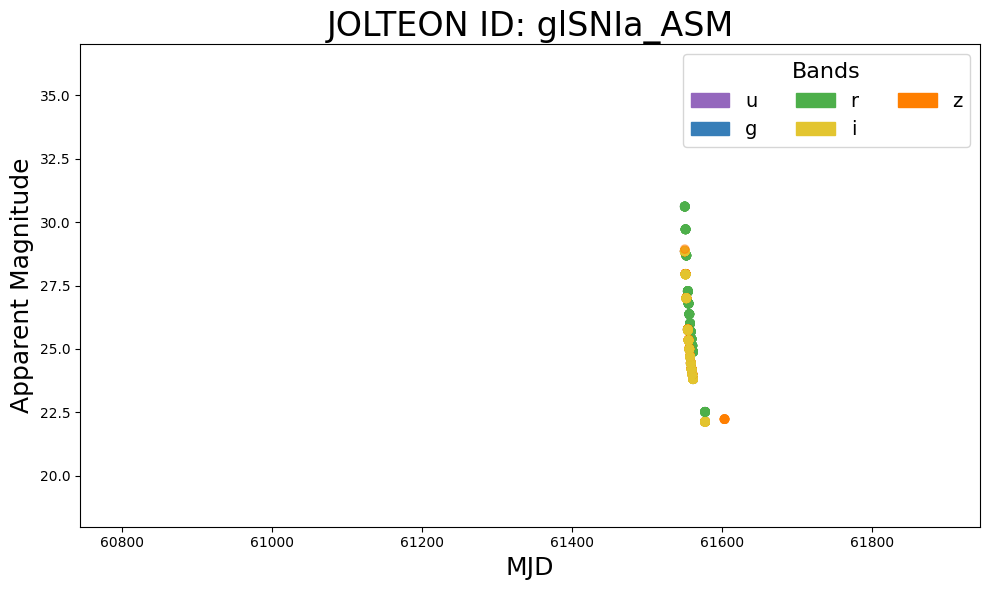

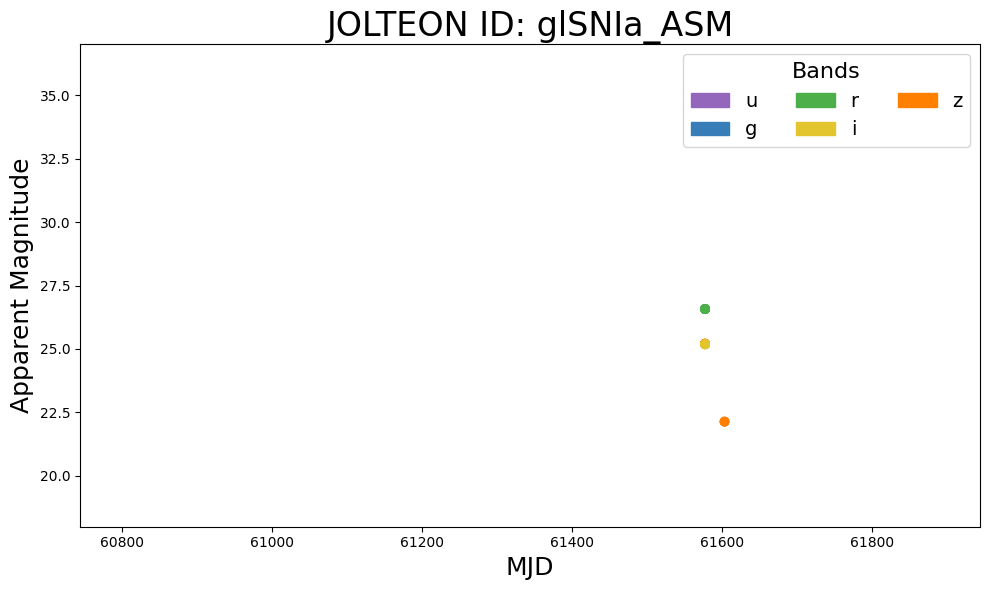

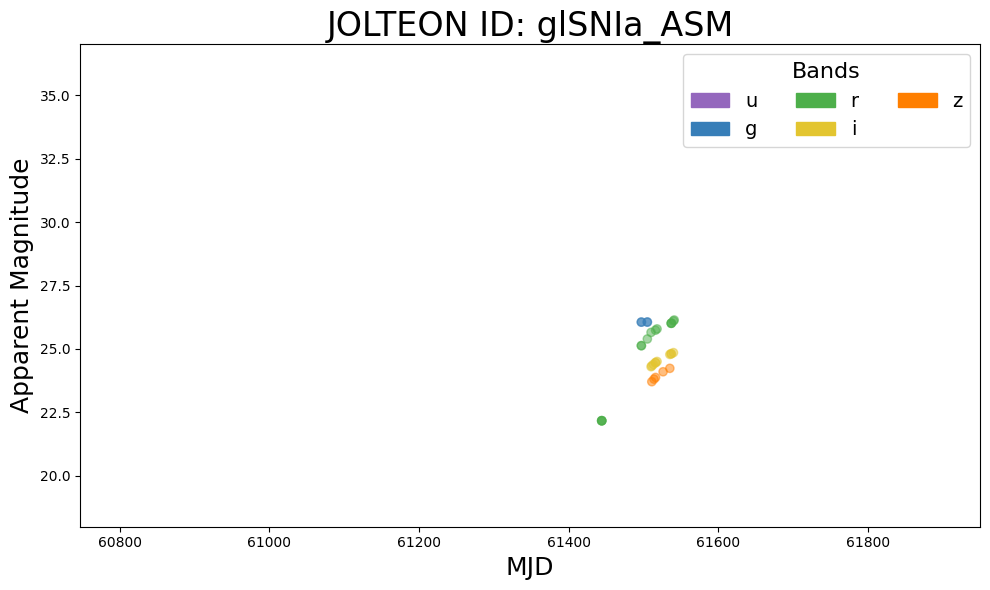

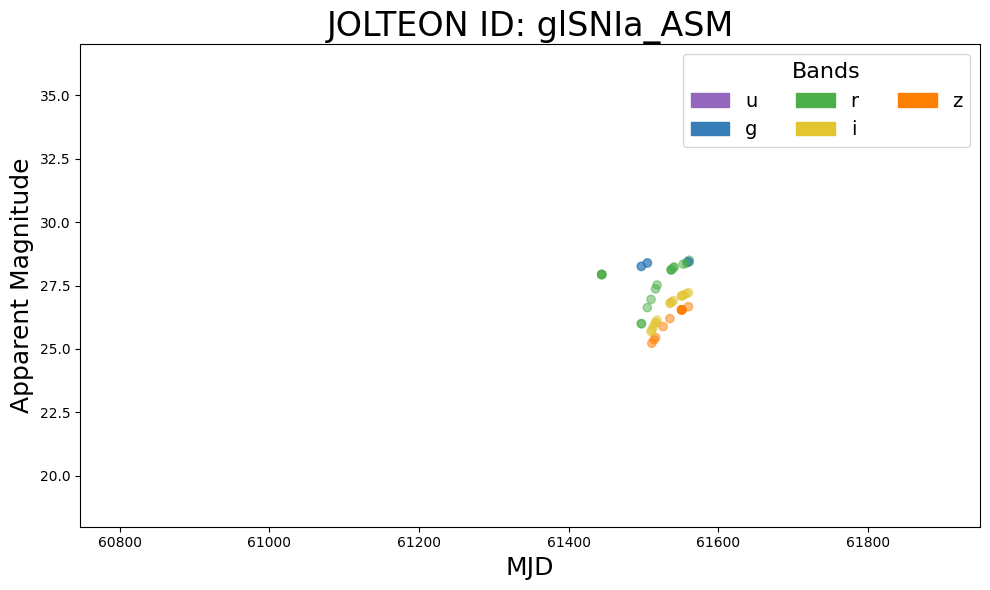

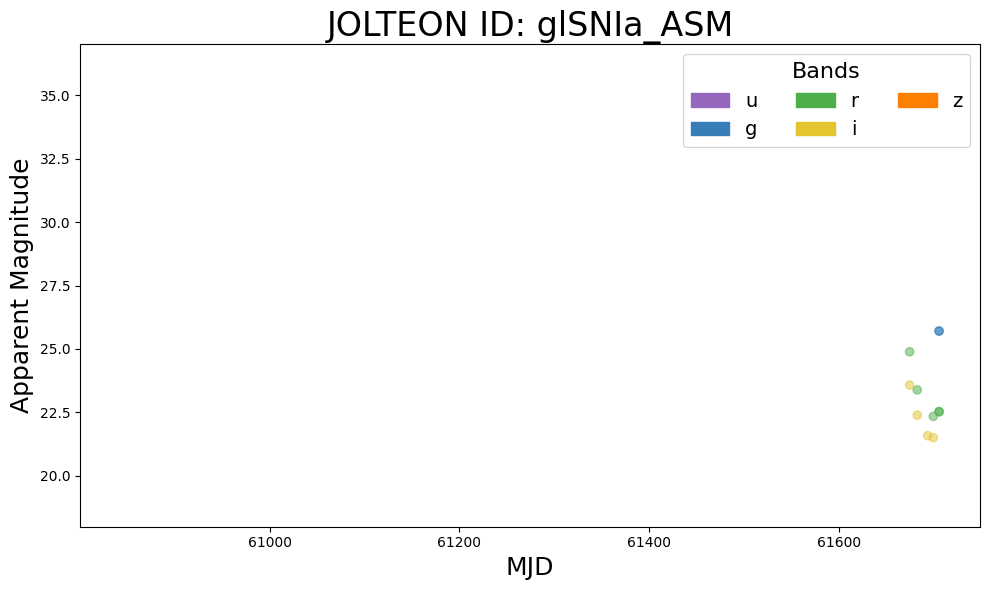

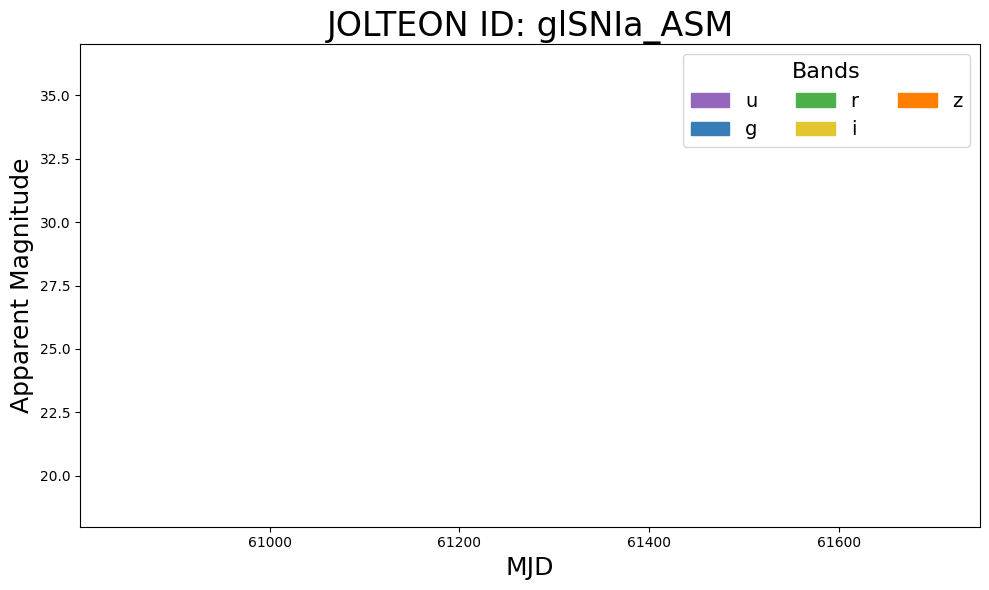

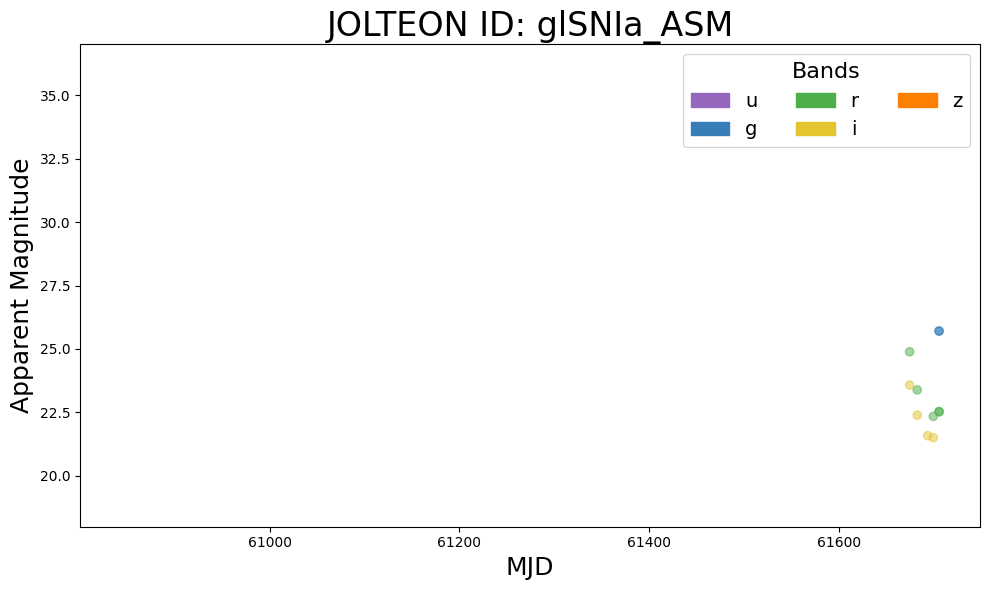

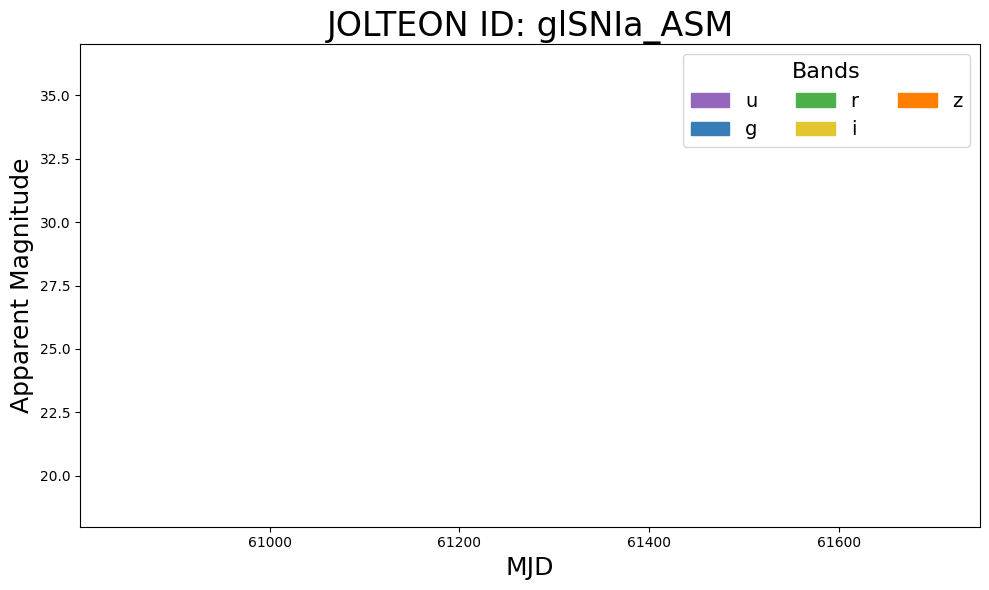

In [36]:
for obj in nolensed:
    if obj[1] == 'glSNIa_ASM':
        for i in range(len(sn_list)):
            if obj[0] == sn_list[i].snid:
                sn_list[i].sn_plot()

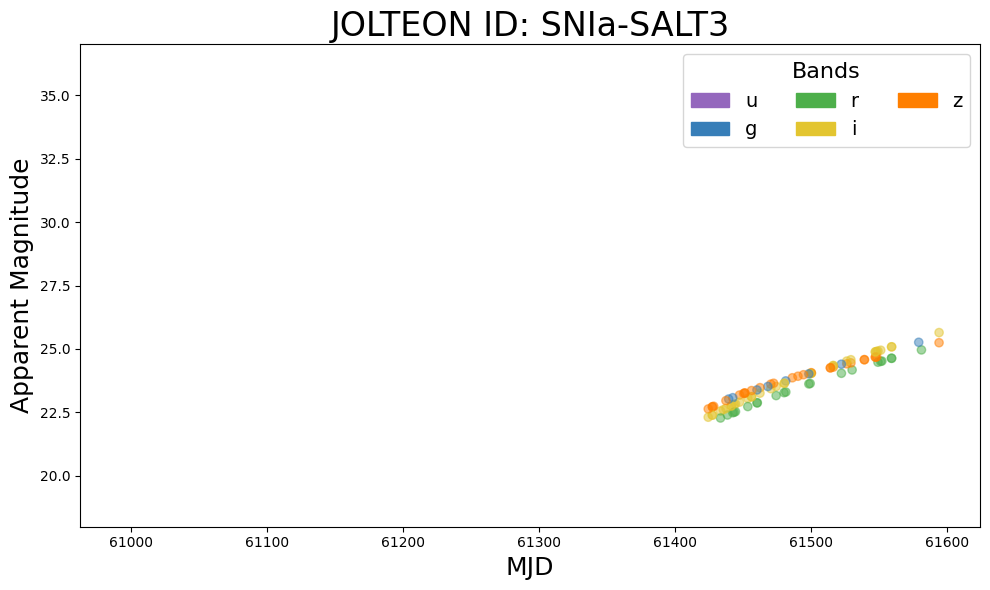

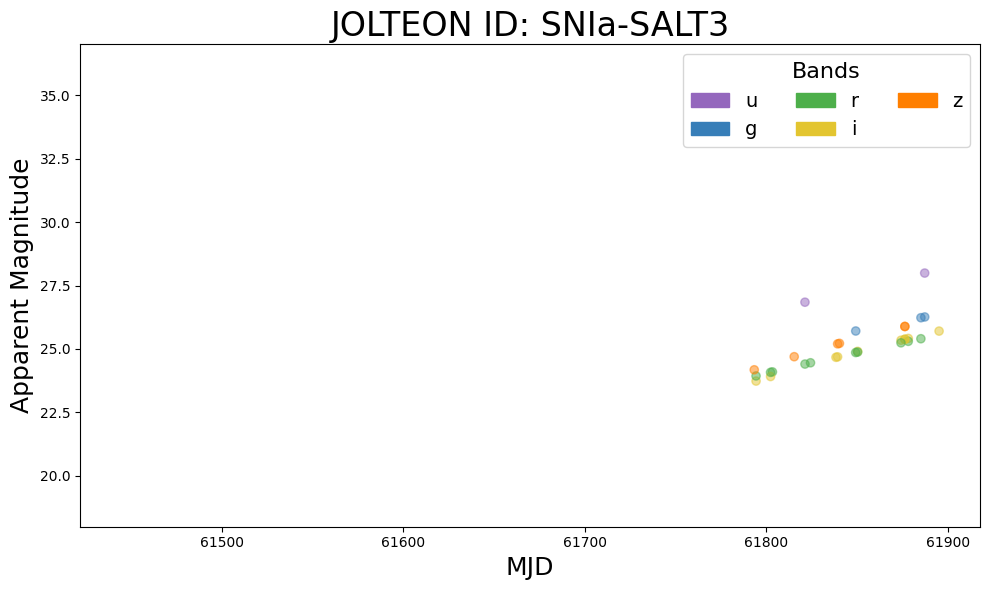

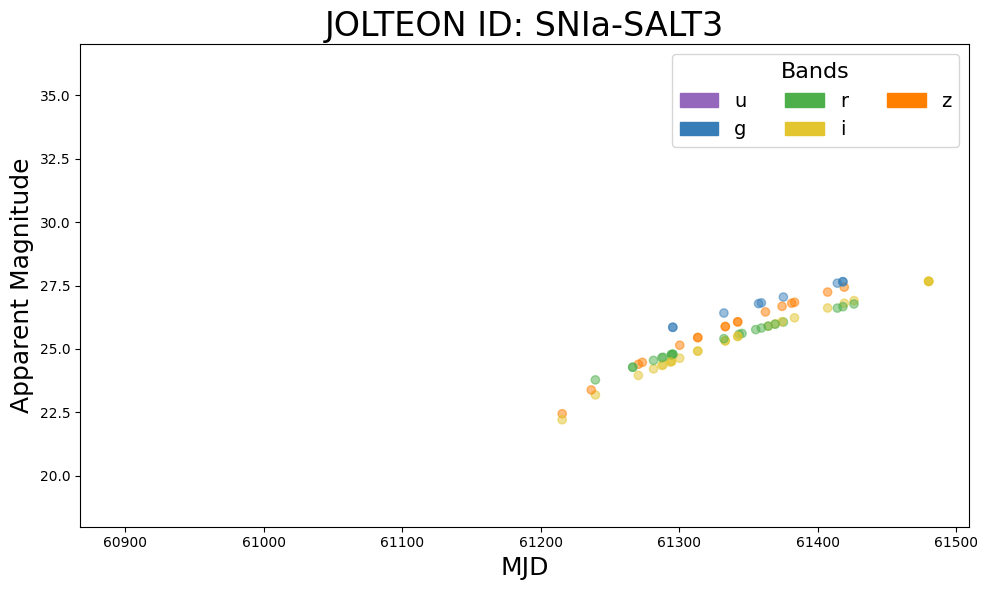

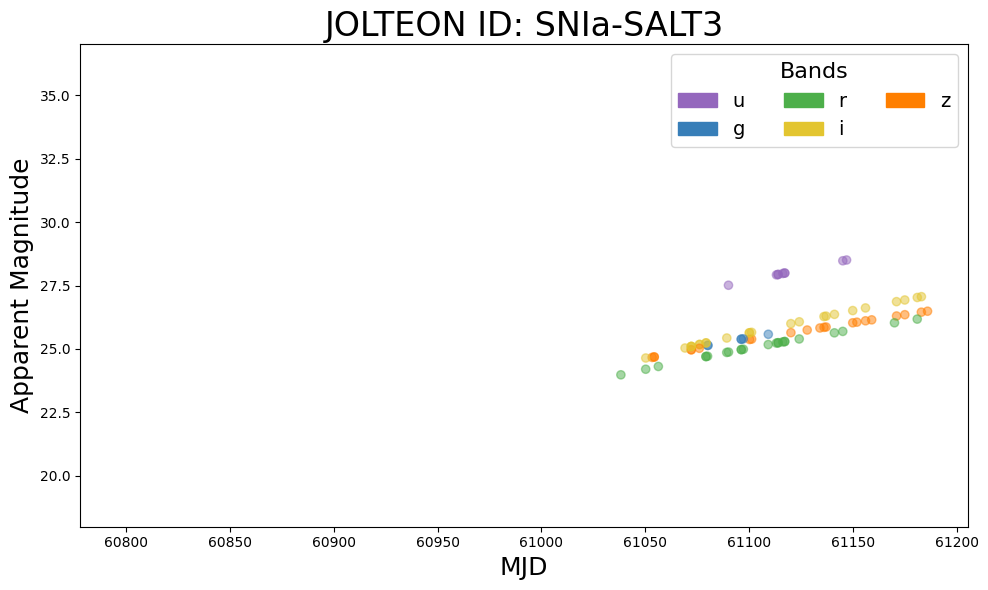

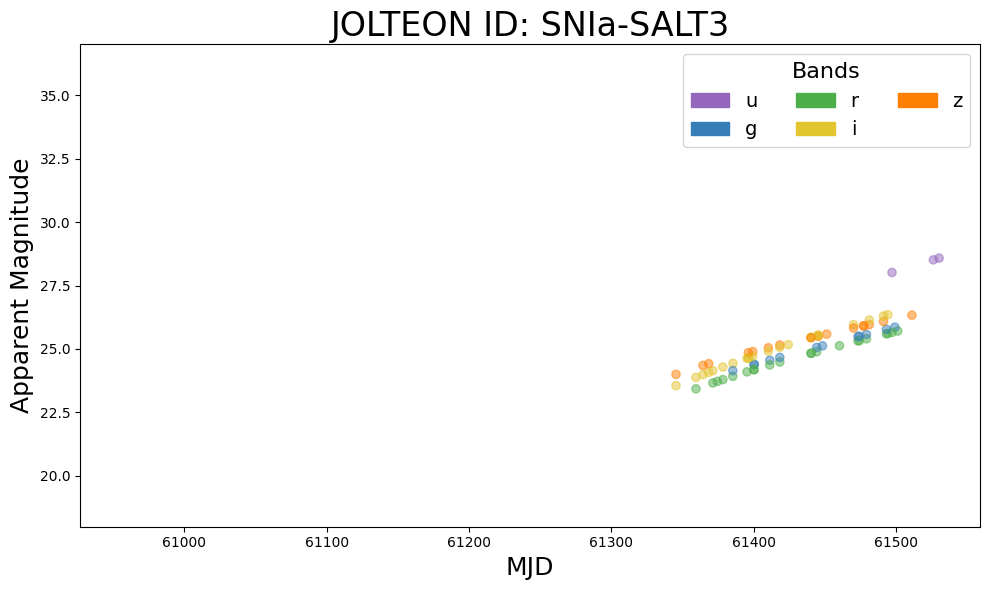

In [34]:
for obj in yeslensed:
    if obj[1] == 'SNIa-SALT3':
        for i in range(len(sn_list)):
            if obj[0] == sn_list[i].snid:
                sn_list[i].sn_plot()




In [38]:
#1.5, 0.5
nolensed = []
dunnolensed = []
yeslensed = []

for sn_obj in sn_list:
    if sn_obj.mu_s - sn_obj.mu_exp.value > 3.0:
        yeslensed.append([sn_obj.snid, sn_obj.label, sn_obj.mu_s, sn_obj.mu_exp])
    elif sn_obj.mu_s - sn_obj.mu_exp.value < 0.3:
        nolensed.append([sn_obj.snid, sn_obj.label, sn_obj.mu_s, sn_obj.mu_exp])
    else:
        dunnolensed.append([sn_obj.snid, sn_obj.label, sn_obj.mu_s, sn_obj.mu_exp])

print(len(yeslensed), len(dunnolensed), len(nolensed))

errors_lens = 0
for obj in yeslensed:
    if obj[1] == 'SNIa-SALT3':
        errors_lens += 1
print(errors_lens)

errors_nolens = 0
for obj in nolensed:
    if obj[1] == 'glSNIa_ASM':
        errors_nolens += 1
print(errors_nolens)

27 561 1937
5
41


In [ ]:
lenseds = 0
for obj in sn_list:
    if obj.label =='glSNIa_ASM':
        lenseds += 1
print(lenseds)

In [ ]:
for sn_obj in sn_list:
    if sn_obj.sus: 
        print(f"{sn_obj.snid:<10} {sn_obj.label:<20} {sn_obj.mu_s:<10.3f} {sn_obj.mu_b:<10.3f} {sn_obj.mu_exp:<10.3f}")


In [9]:
''' DO NOT RUN WHEN FIRST OPENING THIS
with open('sn_list.pkl', 'wb') as f:
    pickle.dump(sn_list, f)

print("sn_list saved successfully as sn_list.pkl")
'''

sn_list saved successfully as sn_list.pkl


In [40]:
with open('sn_list.pkl', 'rb') as f:
    loaded_sn_list = pickle.load(f)

print("sn_list loaded successfully from sn_list.pkl")
print(f"Number of SN objects loaded: {len(loaded_sn_list)}")

# You can now access attributes of the loaded objects
if loaded_sn_list:
    first_sn = loaded_sn_list[2500]
    print(f"First SNID: {first_sn.snid}")
    print(f"First SN's redshift: {first_sn.z}")
    print(f"First SN's light curve (first 3 rows):\n{first_sn.lc[:3]}")
    # You can also call its methods
    # first_sn.sn_plot()

sn_list loaded successfully from sn_list.pkl
Number of SN objects loaded: 2525
First SNID: 104955
First SN's redshift: 0.6652253688368704
First SN's light curve (first 3 rows):
   MJD     BAND      FLUXCAL       ... ZEROPT     SIM_MAGOBS    
---------- ---- ------------------ ... ------ ------------------
61527.1163    i -9.865019682717389 ...   27.5 29.941556930541992
 61527.092    r  2.682262464073708 ...   27.5  31.12018394470215
61518.1119    z -5.345959637983611 ...   27.5  29.68543243408203
